In [140]:
# from gekko import GEKKO

# # Create GEKKO model
# m = GEKKO(remote=False)
# m.time = np.linspace(0, 100, 100)

# # Variables
# x1 = m.Var(value=1)
# x2 = m.Var(value=0)
# u = m.MV(value=0, lb=-1, ub=1)
# u.STATUS = 1  # Allow the optimizer to change the MV

# # Nonlinear model equations
# m.Equation(x1.dt() == x2)
# m.Equation(x2.dt() == -x1 + x2**2 * u)

# # Objective: Minimize (x1-1)**2 + x2**2 + u**2
# m.Obj(1*(x1-1)**2 + x2**2 + u**2)

# # Set MPC mode
# m.options.IMODE = 6  # MPC mode
# m.options.CV_TYPE = 2 # Squared Error
# m.options.NODES = 3  # Collocation points
# m.options.SOLVER = 3  # IPOPT solver

# # Solve the optimization problem
# m.solve(disp=False)

# # Plot results
# plt.figure()
# plt.subplot(2,1,1)
# plt.plot(m.time, x1.value, 'r-', label='x1')
# plt.plot(m.time, x2.value, 'b--', label='x2')
# plt.legend()
# plt.ylabel('States')
# plt.subplot(2,1,2)
# plt.plot(m.time, u.value, 'g-', label='u')
# plt.legend()
# plt.ylabel('Control')
# plt.xlabel('Time')
# plt.show() 

## OTHER
# # Define Control and Prediction Horizon (only if m.options.CSV_READ = 0) (not recommended online)
# m.options.CSV_READ = 0
# m.options.CTRL_HOR = 10
# m.options.CTRL_TIME = 1
# m.options.PRED_HOR = 40
# m.options.PRED_TIME = 1


## Different time definitions for m.time
# m.time = np.concatenate([m.time, np.arange(m.time[1] + 1, m.time[1] + 5)])
        
# m.time = np.linspace(tspan[ct], tspan[ct+1], 3)

# m.time = np.linspace(tspan[ct], tspan[ct+1], 2)
# t0 = m.time[1]+1
# m.time = np.concatenate([m.time, [t0 + 3, t0 + 9]])


# for species_name, species_list in VAR.species_cells.items():
#     for species_properties in species_list:
#         species_name = species_properties.sym_name
#         species_idx = speciesName_list.index(species_name)

In [141]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from scipy.integrate import solve_ivp
from scipy.special import erfinv
import scipy.io
import pandas as pd
import time
from gekko import GEKKO
from tqdm import tqdm

def MC2SSEM_population(popMC, VAR):
    """
    Creates the initial population used by SSEM, divided by species and altitude bin,
    starting from the MC population. 
    """
    # popMC = sats
    # VAR = baseline

    # Filter species based on VAR.species_types 
    active_species_indices = []
    for index, species in enumerate(VAR.species_types):
        if species:
            active_species_indices.append(index + 1)

    # Initialize lists to store classified objects
    popMC_S = []; popMC_D = []; popMC_N = []; popMC_Su = []; popMC_B = []; popMC_U = []

    # Object classification categories
    potential_payload_classes = ['Payload', 'Payload Mission Related Object', 'Other Mission Related Object', 'Rocket Mission Related Object']
    debris_classes = ['Other Debris', 'Payload Debris', 'Payload Fragmentation Debris', 'Rocket Debris', 'Rocket Fragmentation Debris']
    untracked_debris_classes = ['Untracked Debris']
    rocket_body_classes = ['Rocket Body']

    # Classify objects based on their properties
    for sat in popMC:
        alt = sat[0]['a'] * VAR.re - VAR.re  # Calculate altitude
    
        # Check if object is within altitude boundaries (% Outside boundaries TO DO: understand why this is not an || ?)
        if alt < VAR.min_altitude and alt > VAR.max_altitude:
            continue

        # Classify based on objectclass and control status 
        if any(obj_class in sat[0]['objectclass'] for obj_class in potential_payload_classes):
            if 1 in active_species_indices and 4 in active_species_indices:  # S and Su exist
                # MOCAT-4S
                if sat[0]['controlled'] == 1 and sat[0]['constel'] == 0:  # Active payload
                    if 4 in active_species_indices:
                        popMC_Su.append(sat)
                elif sat[0]['controlled'] == 1 and sat[0]['constel'] == 1: # Constellation
                    if 1 in active_species_indices:
                        popMC_S.append(sat)
                elif sat[0]['controlled'] == 0:  # Inactive payload (derelict)
                    if 2 in active_species_indices:
                        popMC_D.append(sat)
            else:
                # MOCAT-3
                if sat[0]['controlled'] == 1:
                    if 4 in active_species_indices:
                        popMC_Su.append(sat)
                else:
                    if 2 in active_species_indices:
                        popMC_D.append(sat)
        elif any(obj_class in sat[0]['objectclass'] for obj_class in debris_classes):
            if 3 in active_species_indices:
                popMC_N.append(sat)
        elif any(obj_class in sat[0]['objectclass'] for obj_class in rocket_body_classes): 
            if 5 in active_species_indices:
                popMC_B.append(sat)
        elif any(obj_class in sat[0]['objectclass'] for obj_class in untracked_debris_classes): 
            if 6 in active_species_indices:
                popMC_U.append(sat)

    # Create count lists for each species
    pop_list = [popMC_S, popMC_D, popMC_N, popMC_Su, popMC_B, popMC_U]
    count_list = np.zeros((len(pop_list), 0)).tolist()
    speciesName_list = ['Su', 'D', 'N', 'S', 'B', 'U']

    i1 = 0
    for speciesName, pop in zip(speciesName_list, pop_list):
        for species_properties in VAR.species_cells.get(speciesName, []):
            count = np.zeros((VAR.n_shells, 1))
            count_list[i1].append(count)
        i1 += 1

    # Bin objects by altitude and mass
    for species_idx, count in enumerate(count_list):
        if not count:
            continue
        for shell_idx in range(VAR.n_shells - 1):
            pop = pop_list[species_idx]
            speciesName = speciesName_list[species_idx]

            for sat in pop:
                alt = sat[0]['a'] * VAR.re - VAR.re

                if VAR.R0_km[shell_idx] <= alt < VAR.R0_km[shell_idx + 1]:
                    for species_properties in VAR.species_cells.get(speciesName, []):
                        mass_idx = 0
                        if (species_properties.mass_lb < sat[0]['mass'] <= species_properties.mass_ub):
                            count[mass_idx][shell_idx] += 1
                            break  # Object assigned to a mass bin, move to next object

    # Assemble popSSEM based on VAR.species order 
    popSSEM = np.zeros((VAR.n_shells, 0))

    for species_name, species_list in VAR.species_cells.items():
        species_idx = speciesName_list.index(species_name)
        if species_idx < len(count_list):
            popSSEM = np.hstack((popSSEM, count_list[species_idx][0]))

    return popSSEM.T.flatten().astype(int)

def randn2(*args,**kwargs):
    '''
    Calls rand and applies inverse transform sampling to the output.
    '''
    uniform = np.random.rand(*args, **kwargs)
    return np.sqrt(2) * erfinv(2 * uniform - 1)

colors = [[0, 0, 0], [0, 0.4470, 0.7410], [0.8500, 0.3250, 0.0980], 
          [0.9290, 0.6940, 0.1250], [0.4940, 0.1840, 0.5560], [0.4660, 0.6740, 0.1880]]
sel_LineWidth = 3
sel_LineWidth2 = 1.5
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14  
# folder = '/Users/glavezzi/Library/CloudStorage/Box-Box/MIT/PROJETCS/SSEM/Draft/AAS24/figure' 

 Shell   Su    N   D
     1    0   23   8
     2    7   15   3
     3   38   32  10
     4   44   91  31
     5  172  186 114
     6  456  227  91
     7 2977  194 117
     8  379  309  98
     9  157  340 129
    10   79  519 120
    11   59  829 150
    12  144 1224 215
    13   43 1381 144
    14   17 1160  80
    15   15  695 116
    16   10  488 288
    17    1  353  56
    18   43  256  73
    19    3  207  35
    20  101  145  39
    21  277  104  11
    22    0  244   9
    23    2   86  18
    24    0  106  40
    25   37  107 275
    26   50  174 227
    27    4  192  56
    28    0  144  20
    29    0   93  18
    30    0   58  18
    31    1   20   6
    32    0   26   3
    33    0   23   3
    34    0   19   5
    35    0   14   3
    36    0    0   0


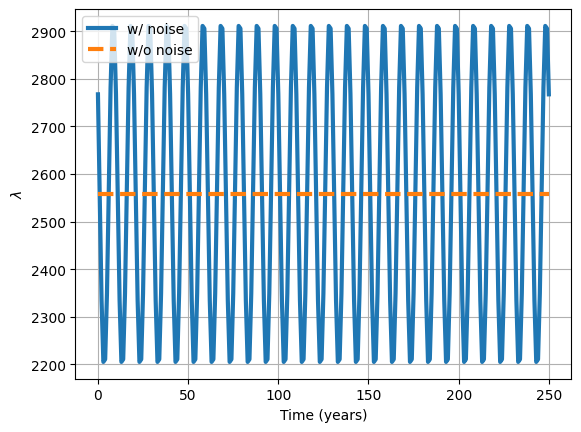

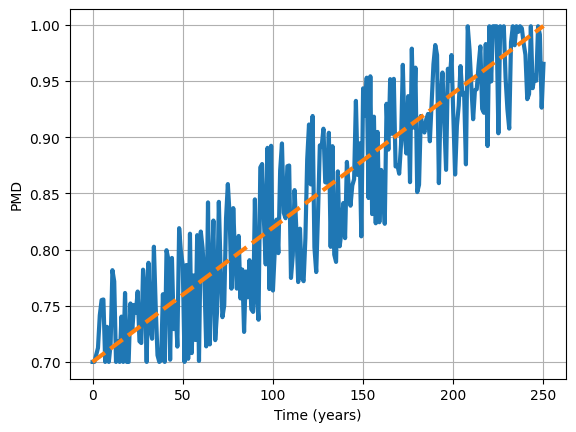

In [142]:
# import pickle file 
with open('../scenario-properties-test.pkl', 'rb') as f:
    baseline = pickle.load(f)

# Selection
np.random.seed(25) # Seed for reproducibility
sel_ic = 2 # 1: IC from predefined array; 2: IC from MC2SSEM_population 
sel_controller = 2; # 1: PD, 2: NMPC

# Parameters
N_shell = baseline.n_shells
R02 = baseline.R0_km

tf_ss = 250
dur = tf_ss
Ts = 1
tspan = np.arange(0, dur+Ts, Ts)

# ODE tolerances
rtol = 1e-2
atol = 1e-2

#==========================================================================
# Control Settings
#==========================================================================
# PD gains - Launch rate (lambda)
K_p = 0 * 1
K_d = 0 * 0.5

# PD gains - Active Debris Removal (ADR)
K_p_adrD = 1 * 1
K_d_adrD = 1 * 1
K_p_adrN = 1 * 1
K_d_adrN = 1 * 1

# MPC - Prediction horizon steps
Tp = 5

# MPC - Control horizon steps
Tc = 3 # Positive integer, m, between 1 and p, inclusive, 
# where p is equal to PredictionHorizon. In this case, the controller computes 
# m free control moves occurring at times k through k+m-1, and holds the controller 
# output constant for the remaining prediction horizon steps from k+m through k+p-1. 
# Here, k is the current control interval.
# The product of Tp and Ts is the prediction time; that is,
# how far the controller looks into the future.

# ADR Saturation Functions (Lambda Functions)
# sat_D = lambda t: -(2 + np.floor(t / 10) * 5) # increase every 10 years
# sat_N = lambda t: -(2 + np.floor(t / 10) * 5)
sat_D = lambda t: -(2 + np.floor(t / 5) * 5) # increase every 5 years
sat_N = lambda t: -(2 + np.floor(t / 5) * 5)

#==========================================================================
# Initial conditions
#==========================================================================
if sel_ic == 1:
    # Mean and standard deviation values
    S_mean = 142
    S_std = 497
    D_mean = 73
    D_std = 79
    N_mean = 280
    N_std = 354

    # Generate random values and create initial conditions
    S_rand = randn2(N_shell)
    x0_S = np.abs(np.round(S_mean + S_std * S_rand)).astype(int)
    D_rand = randn2(N_shell)
    x0_D = np.abs(np.round(D_mean + D_std * D_rand)).astype(int)
    N_rand = randn2(N_shell)
    x0_N = np.abs(np.round(N_mean + N_std * N_rand)).astype(int)

    # Combine initial conditions
    x0 = np.concatenate((x0_S, x0_N, x0_D))
    spec_names = ["Su", "N", "D"]
    VAR = {"N_shell": N_shell}  

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

if sel_ic == 2:
    # change order of Su with S
    baseline.species_types = [
        'Su' in baseline.species_cells and baseline.species_cells['Su'],
        'D' in baseline.species_cells and baseline.species_cells['D'],
        'N' in baseline.species_cells and baseline.species_cells['N'],
        'S' in baseline.species_cells and baseline.species_cells['S'],
        'B' in baseline.species_cells and baseline.species_cells['B'],
        'U' in baseline.species_cells and baseline.species_cells['U']
    ]
    mass_lb = 0.00141372; # lower bound of mass class for object binning (inclusive), 1 cm diameter Al sphere
    mass_ub = 100000; # upper bound of mass class for object binning (exclusive, except for top mass bin, which is inclusive)
    for species_name, species_list in baseline.species_cells.items():
        for species_properties in species_list:
            species_properties.mass_lb = mass_lb
            species_properties.mass_ub = mass_ub
    init_mat = scipy.io.loadmat('initialized.mat')
    sats = init_mat['sats']
    x0 = MC2SSEM_population(sats, baseline)
    spec_names = ["Su", "N", "D"]

    # Create pandas DataFrame (equivalent to MATLAB's table)
    df = pd.DataFrame(x0.reshape((3,N_shell)).T, columns=spec_names)
    # print(df.to_string(index=False)) # Print DataFrame without index
    x0_S = df['Su'].values
    x0_D = df['D'].values
    x0_N = df['N'].values

    # Print table with shell numbers (optional)
    df_with_shell = pd.DataFrame(np.column_stack((np.arange(1, N_shell+1),x0.reshape((3,N_shell)).T)), 
                                   columns=['Shell'] + spec_names)
    print(df_with_shell.to_string(index=False)) # Print DataFrame without index

#==========================================================================
# Reference values
#==========================================================================
ref_S = x0_S * 2 * 1
ref_D = x0_D * 0.5 * 1
ref_N = x0_N * 0.5 * 1
ref_S_dot = np.ones(N_shell) * 0.5 * 0
ref_D_dot = np.ones(N_shell) * 0 * 0
ref_N_dot = np.ones(N_shell) * -0.8 * 0

#==========================================================================
# Launch rate (lambda) selection
#==========================================================================
# Lambda functions for launch rate selection
def x0_lam_f1(t):
    return np.zeros(N_shell)

def x0_lam_f2(t):
    return 0.5 * x0_S

def x0_lam_f3(t):
    return np.random.rand(N_shell) * x0_S

# Define parameters for x0_lam_f4
lam_mean = 150
lam_std = 30

def x0_lam_f4(t):
    return np.round(lam_mean + lam_std * randn2(N_shell)).astype(int)

# Define phase shifts for x0_lam_f5
phase_shifts = 2 * np.pi / np.random.randint(1, N_shell + 1, size=N_shell)

def x0_lam_f5(t):
    return 0.5 * x0_S * (np.cos((2*np.pi/10)*t + phase_shifts) / 6 + 1)

# Initialize arrays 
x0_lam_no_noise = np.zeros((N_shell, len(tspan)))
x0_lam = np.zeros((N_shell, len(tspan)))

# Evaluate lambda functions for each time step
for i1 in range(len(tspan)):
    x0_lam_no_noise[:, i1] = x0_lam_f2(tspan[i1])
    x0_lam[:, i1] = x0_lam_f5(tspan[i1]) 


# Figure: lambda with and without noise
plt.figure(facecolor='white')
plt.xlabel('Time (years)')
plt.ylabel('$\lambda$')
plt.grid(True)

plt.plot(sum(x0_lam), linewidth=sel_LineWidth, label='w/ noise')
plt.plot(sum(x0_lam_no_noise), '--', linewidth=sel_LineWidth, label='w/o noise')

plt.legend(loc='best')
plt.show()

#==========================================================================
# PMD selection
#==========================================================================

# 1. Constant PMD
PMD1 = 0.9 * np.ones_like(tspan)

# 2. Increasing PMD
n = len(tspan)
lower_bound = 0.7
upper_bound = 0.999
base_sequence = np.linspace(0, 1, n)
PMD2 = lower_bound + (base_sequence * (upper_bound - lower_bound))

# 3. Increasing PMD with Randomness
base_sequence = np.linspace(0, 1, n)
random_variations = (np.random.rand(n) - 0.5) * 0.5 
final_sequence = base_sequence + random_variations
final_sequence = np.clip(final_sequence, 0, upper_bound) # Keep values within [0, upper_bound]
PMD3 = lower_bound + (final_sequence * (upper_bound - lower_bound))

PMD_no_noise = PMD2
PMD = PMD3

# # Figure: PMD vs Time
# plt.figure(facecolor='white')  # Set figure size
# plt.title('PMD vs Time')
# plt.xlabel('Time (years)')
# plt.ylabel('P_M (%)')
# plt.grid(True)

# plt.plot(tspan, PMD1 * 100, linewidth=sel_LineWidth, color=colors[1], label="P$_M^{\#1}$")  # Python uses 0-based indexing for colors
# plt.plot(tspan, PMD2 * 100, linewidth=sel_LineWidth, color=colors[2], label="P$_M^{\#2}$")
# plt.plot(tspan, PMD3 * 100, linewidth=sel_LineWidth, color=colors[3], label="P$_M^{\#3}$")

# plt.xticks(fontsize=sel_FontSize)
# plt.yticks(fontsize=sel_FontSize)
# plt.gca().tick_params(width=sel_LineWidthAxis)
# plt.legend(loc='best')

# plt.savefig('pmd_opt.pdf', format='pdf', dpi=300)  # Save as PDF with 300 DPI

# Figure: PMD with and without noise
plt.figure(facecolor='white')
plt.xlabel('Time (years)')
plt.ylabel('PMD')
plt.grid(True)

plt.plot(PMD, linewidth=sel_LineWidth, label='w noise')
plt.plot(PMD_no_noise, '--', linewidth=sel_LineWidth, label='w/o noise')

# plt.legend(loc='best')
plt.show()

#==========================================================================
# MOCAT parameters selection
#==========================================================================

Alpha_no_noise = 0.15 * np.ones_like(tspan) 
alpha_active_no_noise = 0.015 * np.ones_like(tspan) 
Delta_no_noise = 5 * np.ones_like(tspan)

Alpha = Alpha_no_noise + 1 * Alpha_no_noise / 3.5 * np.random.randn(*tspan.shape)
alpha_active = alpha_active_no_noise + 1 * alpha_active_no_noise / 3.5 * np.random.randn(*tspan.shape)
Delta = Delta_no_noise + 1 * Delta_no_noise / 3 * np.random.randn(*tspan.shape)


In [143]:
# MOCAT-3 w/o debris spreading function (from matlab)
# 200-2000 km, 36 shells
# Case 3 - controller paper

lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14, lambda_15, lambda_16, lambda_17, lambda_18, lambda_19, lambda_20, lambda_21, lambda_22, lambda_23, lambda_24, lambda_25, lambda_26, lambda_27, lambda_28, lambda_29, lambda_30, lambda_31, lambda_32, lambda_33, lambda_34, lambda_35, lambda_36 = sp.symbols('lambda_1 lambda_2 lambda_3 lambda_4 lambda_5 lambda_6 lambda_7 lambda_8 lambda_9 lambda_10 lambda_11 lambda_12 lambda_13 lambda_14 lambda_15 lambda_16 lambda_17 lambda_18 lambda_19 lambda_20 lambda_21 lambda_22 lambda_23 lambda_24 lambda_25 lambda_26 lambda_27 lambda_28 lambda_29 lambda_30 lambda_31 lambda_32 lambda_33 lambda_34 lambda_35 lambda_36')
S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14, S_15, S_16, S_17, S_18, S_19, S_20, S_21, S_22, S_23, S_24, S_25, S_26, S_27, S_28, S_29, S_30, S_31, S_32, S_33, S_34, S_35, S_36 = sp.symbols('S_1 S_2 S_3 S_4 S_5 S_6 S_7 S_8 S_9 S_10 S_11 S_12 S_13 S_14 S_15 S_16 S_17 S_18 S_19 S_20 S_21 S_22 S_23 S_24 S_25 S_26 S_27 S_28 S_29 S_30 S_31 S_32 S_33 S_34 S_35 S_36')
N_1, N_2, N_3, N_4, N_5, N_6, N_7, N_8, N_9, N_10, N_11, N_12, N_13, N_14, N_15, N_16, N_17, N_18, N_19, N_20, N_21, N_22, N_23, N_24, N_25, N_26, N_27, N_28, N_29, N_30, N_31, N_32, N_33, N_34, N_35, N_36 = sp.symbols('N_1 N_2 N_3 N_4 N_5 N_6 N_7 N_8 N_9 N_10 N_11 N_12 N_13 N_14 N_15 N_16 N_17 N_18 N_19 N_20 N_21 N_22 N_23 N_24 N_25 N_26 N_27 N_28 N_29 N_30 N_31 N_32 N_33 N_34 N_35 N_36')
D_1, D_2, D_3, D_4, D_5, D_6, D_7, D_8, D_9, D_10, D_11, D_12, D_13, D_14, D_15, D_16, D_17, D_18, D_19, D_20, D_21, D_22, D_23, D_24, D_25, D_26, D_27, D_28, D_29, D_30, D_31, D_32, D_33, D_34, D_35, D_36 = sp.symbols('D_1 D_2 D_3 D_4 D_5 D_6 D_7 D_8 D_9 D_10 D_11 D_12 D_13 D_14 D_15 D_16 D_17 D_18 D_19 D_20 D_21 D_22 D_23 D_24 D_25 D_26 D_27 D_28 D_29 D_30 D_31 D_32 D_33 D_34 D_35 D_36')

alpha_active11 = sp.symbols('alpha_active11')
Alpha11 = sp.symbols('Alpha11')
Delta11 = sp.symbols('Delta11')
P1 = sp.symbols('P1')
alpha_active11_flattened = [alpha_active11]
Alpha11_flattened = [Alpha11]
Delta11_flattened = [Delta11]
P1_flattened =[P1]

full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]

mocat3 = [
lambda_1 - S_1/8 - ((7625858808779829*N_1*S_1)/302231454903657293676544 + (6070554391111943*D_1*S_1)/75557863725914323419136)*(Alpha11 + Delta11) - (6070554391111943*S_1**2*alpha_active11)/75557863725914323419136,
lambda_2 - S_2/8 - (5979653684263011*S_2**2*alpha_active11)/75557863725914323419136 - ((7511668915833121*N_2*S_2)/302231454903657293676544 + (5979653684263011*D_2*S_2)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_3 - S_3/8 - ((7400024772619095*N_3*S_3)/302231454903657293676544 + (5890779517979007*D_3*S_3)/75557863725914323419136)*(Alpha11 + Delta11) - (5890779517979007*S_3**2*alpha_active11)/75557863725914323419136,
lambda_4 - S_4/8 - (2901936048689957*S_4**2*alpha_active11)/37778931862957161709568 - ((7290851264529905*N_4*S_4)/302231454903657293676544 + (2901936048689957*D_4*S_4)/37778931862957161709568)*(Alpha11 + Delta11),
lambda_5 - S_5/8 - (5718873816800171*S_5**2*alpha_active11)/75557863725914323419136 - ((1796019006764785*N_5*S_5)/75557863725914323419136 + (5718873816800171*D_5*S_5)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_6 - S_6/8 - (1408932291076631*S_6**2*alpha_active11)/18889465931478580854784 - ((7079629325856703*N_6*S_6)/302231454903657293676544 + (1408932291076631*D_6*S_6)/18889465931478580854784)*(Alpha11 + Delta11),
lambda_7 - S_7/8 - ((6977443942842355*N_7*S_7)/302231454903657293676544 + (5554384631038873*D_7*S_7)/75557863725914323419136)*(Alpha11 + Delta11) - (5554384631038873*S_7**2*alpha_active11)/75557863725914323419136,
lambda_8 - S_8/8 - ((3438727534016131*N_8*S_8)/151115727451828646838272 + (684348578137367*D_8*S_8)/9444732965739290427392)*(Alpha11 + Delta11) - (684348578137367*S_8**2*alpha_active11)/9444732965739290427392,
lambda_9 - S_9/8 - (5396891389725857*S_9**2*alpha_active11)/75557863725914323419136 - ((6779600196750797*N_9*S_9)/302231454903657293676544 + (5396891389725857*D_9*S_9)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_10 - S_10/8 - (5320644925518711*S_10**2*alpha_active11)/75557863725914323419136 - ((6683819031926099*N_10*S_10)/302231454903657293676544 + (5320644925518711*D_10*S_10)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_11 - S_11/8 - ((6590053391182437*N_11*S_11)/302231454903657293676544 + (2623001458238755*D_11*S_11)/37778931862957161709568)*(Alpha11 + Delta11) - (2623001458238755*S_11**2*alpha_active11)/37778931862957161709568,
lambda_12 - S_12/8 - ((6498247118462385*N_12*S_12)/302231454903657293676544 + (1293230164912541*D_12*S_12)/18889465931478580854784)*(Alpha11 + Delta11) - (1293230164912541*S_12**2*alpha_active11)/18889465931478580854784,
lambda_13 - S_13/8 - (1275338749546429*S_13**2*alpha_active11)/18889465931478580854784 - ((6408345999927995*N_13*S_13)/302231454903657293676544 + (1275338749546429*D_13*S_13)/18889465931478580854784)*(Alpha11 + Delta11),
lambda_14 - S_14/8 - ((6320297683906883*N_14*S_14)/302231454903657293676544 + (5031264257607541*D_14*S_14)/75557863725914323419136)*(Alpha11 + Delta11) - (5031264257607541*S_14**2*alpha_active11)/75557863725914323419136,
lambda_15 - S_15/8 - ((6234051604660863*N_15*S_15)/302231454903657293676544 + (4962608185129471*D_15*S_15)/75557863725914323419136)*(Alpha11 + Delta11) - (4962608185129471*S_15**2*alpha_active11)/75557863725914323419136,
lambda_16 - S_16/8 - ((6149558909771063*N_16*S_16)/302231454903657293676544 + (4895347891850815*D_16*S_16)/75557863725914323419136)*(Alpha11 + Delta11) - (4895347891850815*S_16**2*alpha_active11)/75557863725914323419136,
lambda_17 - S_17/8 - ((3033386195472061*N_17*S_17)/151115727451828646838272 + (2414722898837363*D_17*S_17)/37778931862957161709568)*(Alpha11 + Delta11) - (2414722898837363*S_17**2*alpha_active11)/37778931862957161709568,
lambda_18 - S_18/8 - (Alpha11 + Delta11)*((5985646418056973*N_18*S_18)/302231454903657293676544 + (4764865578804649*D_18*S_18)/75557863725914323419136) - (4764865578804649*S_18**2*alpha_active11)/75557863725914323419136,
lambda_19 - S_19/8 - (1175393029420481*S_19**2*alpha_active11)/18889465931478580854784 - ((369133554766765*N_19*S_19)/18889465931478580854784 + (1175393029420481*D_19*S_19)/18889465931478580854784)*(Alpha11 + Delta11),
lambda_20 - S_20/8 - (2319765727617279*S_20**2*alpha_active11)/37778931862957161709568 - ((5828201106032907*N_20*S_20)/302231454903657293676544 + (2319765727617279*D_20*S_20)/37778931862957161709568)*(Alpha11 + Delta11),
lambda_21 - S_21/8 - ((1437949461467713*N_21*S_21)/75557863725914323419136 + (2289355372659091*D_21*S_21)/37778931862957161709568)*(Alpha11 + Delta11) - (2289355372659091*S_21**2*alpha_active11)/37778931862957161709568,
lambda_22 - S_22/8 - (4519078211232463*S_22**2*alpha_active11)/75557863725914323419136 - ((5676887177742541*N_22*S_22)/302231454903657293676544 + (4519078211232463*D_22*S_22)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_23 - S_23/8 - (4460603104207705*S_23**2*alpha_active11)/75557863725914323419136 - ((700428809362465*N_23*S_23)/37778931862957161709568 + (4460603104207705*D_23*S_23)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_24 - S_24/8 - (8806511327517759*S_24**2*alpha_active11)/151115727451828646838272 - ((2765695176040975*N_24*S_24)/151115727451828646838272 + (8806511327517759*D_24*S_24)/151115727451828646838272)*(Alpha11 + Delta11),
lambda_25 - S_25/8 - (8694014159624859*S_25**2*alpha_active11)/151115727451828646838272 - ((5460730617940131*N_25*S_25)/302231454903657293676544 + (8694014159624859*D_25*S_25)/151115727451828646838272)*(Alpha11 + Delta11),
lambda_26 - S_26/8 - ((1347854057393293*N_26*S_26)/75557863725914323419136 + (8583658913030513*D_26*S_26)/151115727451828646838272)*(Alpha11 + Delta11) - (8583658913030513*S_26**2*alpha_active11)/151115727451828646838272,
lambda_27 - S_27/8 - ((2661706624536337*N_27*S_27)/151115727451828646838272 + (8475391555284337*D_27*S_27)/151115727451828646838272)*(Alpha11 + Delta11) - (8475391555284337*S_27**2*alpha_active11)/151115727451828646838272,
lambda_28 - S_28/8 - (8369159747039323*S_28**2*alpha_active11)/151115727451828646838272 - ((2628344400986213*N_28*S_28)/151115727451828646838272 + (8369159747039323*D_28*S_28)/151115727451828646838272)*(Alpha11 + Delta11),
lambda_29 - S_29/8 - (4132456389392877*S_29**2*alpha_active11)/75557863725914323419136 - ((2595605518755415*N_29*S_29)/151115727451828646838272 + (4132456389392877*D_29*S_29)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_30 - S_30/8 - ((640868636326735*N_30*S_30)/37778931862957161709568 + (2040650377581103*D_30*S_30)/37778931862957161709568)*(Alpha11 + Delta11) - (2040650377581103*S_30**2*alpha_active11)/37778931862957161709568,
lambda_31 - S_31/8 - (4031089156423351*S_31**2*alpha_active11)/75557863725914323419136 - ((5063873045515555*N_31*S_31)/302231454903657293676544 + (4031089156423351*D_31*S_31)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_32 - S_32/8 - ((625244237616905*N_32*S_32)/37778931862957161709568 + (3981798506746863*D_32*S_32)/75557863725914323419136)*(Alpha11 + Delta11) - (3981798506746863*S_32**2*alpha_active11)/75557863725914323419136,
lambda_33 - S_33/8 - ((1235290884184017*N_33*S_33)/75557863725914323419136 + (7866812842273115*D_33*S_33)/151115727451828646838272)*(Alpha11 + Delta11) - (7866812842273115*S_33**2*alpha_active11)/151115727451828646838272,
lambda_34 - S_34/8 - (3885891190610095*S_34**2*alpha_active11)/75557863725914323419136 - ((2440737340996463*N_34*S_34)/151115727451828646838272 + (3885891190610095*D_34*S_34)/75557863725914323419136)*(Alpha11 + Delta11),
lambda_35 - S_35/8 - ((2411430442201357*N_35*S_35)/151115727451828646838272 + (7678463515696129*D_35*S_35)/151115727451828646838272)*(Alpha11 + Delta11) - (7678463515696129*S_35**2*alpha_active11)/151115727451828646838272,
lambda_36 - S_36/8 - (Alpha11 + Delta11)*((4765296480972033*N_36*S_36)/302231454903657293676544 + (3793407693859949*D_36*S_36)/75557863725914323419136) - (3793407693859949*S_36**2*alpha_active11)/75557863725914323419136,
(1475365237450109*D_1**2)/36893488147419103232 + (276096517772035*D_1*N_1)/36893488147419103232 + (1475365237450109*Alpha11*D_1*S_1)/36893488147419103232 + (8748393071073325*N_1**2)/1208925819614629174706176 + (276096517772035*Alpha11*N_1*S_1)/36893488147419103232 - (8317334845159471*N_1)/13421772800000 + (13288908667231389425883988770465*alpha_active11*S_1**2)/332306998946228968225951765070086144 + (542423073807987*N_2)/3355443200000,
(1453273063605013*D_2**2)/36893488147419103232 + (8702791624435239*D_2*N_2)/1180591620717411303424 + (1453273063605013*Alpha11*D_2*S_2)/36893488147419103232 + (4308697154201971*N_2**2)/604462909807314587353088 + (8702791624435239*Alpha11*N_2*S_2)/1180591620717411303424 - (542423073807987*N_2)/3355443200000 + (13089920055438230253991494392805*alpha_active11*S_2**2)/332306998946228968225951765070086144 + (5812435927893683*N_3)/107374182400000,
(5726693650935165*D_3**2)/147573952589676412928 + (4286722054270681*D_3*N_3)/590295810358705651712 + (5726693650935165*Alpha11*D_3*S_3)/147573952589676412928 + (4244658016223505*N_3**2)/604462909807314587353088 + (4286722054270681*Alpha11*N_3*S_3)/590295810358705651712 - (5812435927893683*N_3)/107374182400000 + (12895367696208296174215325671785*alpha_active11*S_3**2)/332306998946228968225951765070086144 + (574126180032477*N_4)/26843545600000,
(5642207010033907*D_4**2)/147573952589676412928 + (8446958995518587*D_4*N_4)/1180591620717411303424 + (5642207010033907*Alpha11*D_4*S_4)/147573952589676412928 + (8364072071647129*N_4**2)/1208925819614629174706176 + (8446958995518587*Alpha11*N_4*S_4)/1180591620717411303424 - (574126180032477*N_4)/26843545600000 + (6352560346983975524434653214035*alpha_active11*S_4**2)/166153499473114484112975882535043072 + (7216816671029929*N_5)/858993459200000,
(1389894082659741*D_5**2)/36893488147419103232 + (8323252446046073*D_5*N_5)/1180591620717411303424 + (1389894082659741*Alpha11*D_5*S_5)/36893488147419103232 + (4120789704684049*N_5**2)/604462909807314587353088 + (8323252446046073*Alpha11*N_5*S_5)/1180591620717411303424 - (7216816671029929*N_5)/858993459200000 + (12519052945501733038384718368605*alpha_active11*S_5**2)/332306998946228968225951765070086144 + (6164170016830069*N_6)/1717986918400000,
(2739373823542527*D_6**2)/73786976294838206464 + (8202243668022255*D_6*N_6)/1180591620717411303424 + (2739373823542527*Alpha11*D_6*S_6)/73786976294838206464 + (4060879023145869*N_6**2)/604462909807314587353088 + (8202243668022255*Alpha11*N_6*S_6)/1180591620717411303424 - (6164170016830069*N_6)/1717986918400000 + (3084260732733653731263983365905*alpha_active11*S_6**2)/83076749736557242056487941267521536 + (1087765925690173*N_7)/687194767360000,
(5399668940985057*D_7**2)/147573952589676412928 + (8083854784619459*D_7*N_7)/1180591620717411303424 + (5399668940985057*Alpha11*D_7*S_7)/147573952589676412928 + (2001132717441811*N_7**2)/302231454903657293676544 + (8083854784619459*Alpha11*N_7*S_7)/1180591620717411303424 - (1087765925690173*N_7)/687194767360000 + (12158973515272172202222034887615*alpha_active11*S_7**2)/332306998946228968225951765070086144 + (4987345189090021*N_8)/6871947673600000,
(5322290057517285*D_8**2)/147573952589676412928 + (7968010708957417*D_8*N_8)/1180591620717411303424 + (5322290057517285*Alpha11*D_8*S_8)/147573952589676412928 + (7889823529714485*N_8**2)/1208925819614629174706176 + (7968010708957417*Alpha11*N_8*S_8)/1180591620717411303424 - (4987345189090021*N_8)/6871947673600000 + (1498091469987033876826483053585*alpha_active11*S_8**2)/41538374868278621028243970633760768 + (1143295258276843*N_9)/3435973836800000,
(2623281312940141*D_9**2)/73786976294838206464 + (490914939063499*D_9*N_9)/73786976294838206464 + (2623281312940141*Alpha11*D_9*S_9)/73786976294838206464 + (7777564320705275*N_9**2)/1208925819614629174706176 + (490914939063499*Alpha11*N_9*S_9)/73786976294838206464 - (1143295258276843*N_9)/3435973836800000 + (11814208743445204965656659868535*alpha_active11*S_9**2)/332306998946228968225951765070086144 + (2288140225559289*N_10)/13743895347200000,
(2586219991840899*D_10**2)/73786976294838206464 + (967958734304717*D_10*N_10)/147573952589676412928 + (2586219991840899*Alpha11*D_10*S_10)/73786976294838206464 + (1916921017469185*N_10**2)/302231454903657293676544 + (967958734304717*Alpha11*N_10*S_10)/147573952589676412928 - (2288140225559289*N_10)/13743895347200000 + (11647299391552799517191242096305*alpha_active11*S_10**2)/332306998946228968225951765070086144 + (4579223905443051*N_11)/54975581388800000,
(1274969276259975*D_11**2)/36893488147419103232 + (7635035848888003*D_11*N_11)/1180591620717411303424 + (1274969276259975*Alpha11*D_11*S_11)/36893488147419103232 + (7560116030347583*N_11**2)/1208925819614629174706176 + (7635035848888003*Alpha11*N_11*S_11)/1180591620717411303424 - (4579223905443051*N_11)/54975581388800000 + (5741951157473253819312215007525*alpha_active11*S_11**2)/166153499473114484112975882535043072 + (5229358754387437*N_12)/109951162777600000,
(5028830532189595*D_12**2)/147573952589676412928 + (7528671887663007*D_12*N_12)/1180591620717411303424 + (5028830532189595*Alpha11*D_12*S_12)/147573952589676412928 + (3727397889915475*N_12**2)/604462909807314587353088 + (7528671887663007*Alpha11*N_12*S_12)/1180591620717411303424 - (5229358754387437*N_12)/109951162777600000 + (2830979913859804306758019772955*alpha_active11*S_12**2)/83076749736557242056487941267521536 + (746459074915163*N_13)/27487790694400000,
(4959258310400851*D_13**2)/147573952589676412928 + (3712257590127753*D_13*N_13)/590295810358705651712 + (4959258310400851*Alpha11*D_13*S_13)/147573952589676412928 + (918957640519521*N_13**2)/151115727451828646838272 + (3712257590127753*Alpha11*N_13*S_13)/590295810358705651712 - (746459074915163*N_13)/27487790694400000 + (2791814234844413322574595014395*alpha_active11*S_13**2)/83076749736557242056487941267521536 + (320976882917629*N_14)/17592186044416000,
(2445559963013439*D_14**2)/73786976294838206464 + (3661252536803383*D_14*N_14)/590295810358705651712 + (2445559963013439*Alpha11*D_14*S_14)/73786976294838206464 + (7250652005430821*N_14**2)/1208925819614629174706176 + (3661252536803383*Alpha11*N_14*S_14)/590295810358705651712 - (320976882917629*N_14)/17592186044416000 + (11013822938139528028871281997955*alpha_active11*S_14**2)/332306998946228968225951765070086144 + (5391254985314149*N_15)/439804651110400000,
(4824376247510593*D_15**2)/147573952589676412928 + (3611291491893605*D_15*N_15)/590295810358705651712 + (4824376247510593*Alpha11*D_15*S_15)/147573952589676412928 + (7151710414588039*N_15**2)/1208925819614629174706176 + (3611291491893605*Alpha11*N_15*S_15)/590295810358705651712 - (5391254985314149*N_15)/439804651110400000 + (10863529535291889070086789840105*alpha_active11*S_15**2)/332306998946228968225951765070086144 + (8208595087470461*N_16)/879609302220800000,
(2379494734594887*D_16**2)/73786976294838206464 + (1781173077966755*D_16*N_16)/295147905179352825856 + (2379494734594887*Alpha11*D_16*S_16)/73786976294838206464 + (3527390154041315*N_16**2)/604462909807314587353088 + (1781173077966755*Alpha11*N_16*S_16)/295147905179352825856 - (8208595087470461*N_16)/879609302220800000 + (10716291600051589428568680582825*alpha_active11*S_16**2)/332306998946228968225951765070086144 + (3124429665335317*N_17)/439804651110400000,
(2347461528874855*D_17**2)/73786976294838206464 + (1757194590937573*D_17*N_17)/295147905179352825856 + (2347461528874855*Alpha11*D_17*S_17)/73786976294838206464 + (6959807528511883*N_17**2)/1208925819614629174706176 + (1757194590937573*Alpha11*N_17*S_17)/295147905179352825856 - (3124429665335317*N_17)/439804651110400000 + (5286013433353686351574295252565*alpha_active11*S_17**2)/166153499473114484112975882535043072 + (2601430723115851*N_18)/439804651110400000,
(1158035425295531*D_18**2)/36893488147419103232 + (6934788273761331*D_18*N_18)/1180591620717411303424 + (1158035425295531*Alpha11*D_18*S_18)/36893488147419103232 + (1716684932237917*N_18**2)/302231454903657293676544 + (6934788273761331*Alpha11*N_18*S_18)/1180591620717411303424 - (2601430723115851*N_18)/439804651110400000 + (10430655819685575106523052360495*alpha_active11*S_18**2)/332306998946228968225951765070086144 + (8663710458888817*N_19)/1759218604441600000,
(2285305630058621*D_19**2)/73786976294838206464 + (855333866472977*D_19*N_19)/147573952589676412928 + (2285305630058621*Alpha11*D_19*S_19)/73786976294838206464 + (3387763150405287*N_19**2)/604462909807314587353088 + (855333866472977*Alpha11*N_19*S_19)/147573952589676412928 - (8663710458888817*N_19)/1759218604441600000 + (2573025395989925705711574797655*alpha_active11*S_19**2)/83076749736557242056487941267521536 + (3606582737746369*N_20)/879609302220800000,
(2255149360701333*D_20**2)/73786976294838206464 + (3376188456881811*D_20*N_20)/590295810358705651712 + (2255149360701333*Alpha11*D_20*S_20)/73786976294838206464 + (3343059152507335*N_20**2)/604462909807314587353088 + (3376188456881811*Alpha11*N_20*S_20)/590295810358705651712 - (3606582737746369*N_20)/879609302220800000 + (5078144910259667690088341831145*alpha_active11*S_20**2)/166153499473114484112975882535043072 + (6005349418096997*N_21)/1759218604441600000,
(4451172153813361*D_21**2)/147573952589676412928 + (6663858415402179*D_21*N_21)/1180591620717411303424 + (4451172153813361*Alpha11*D_21*S_21)/147573952589676412928 + (1649617101587877*N_21**2)/302231454903657293676544 + (6663858415402179*Alpha11*N_21*S_21)/1180591620717411303424 - (6005349418096997*N_21)/1759218604441600000 + (5011574313318944972815061393205*alpha_active11*S_21**2)/166153499473114484112975882535043072 + (4999668558026341*N_22)/1759218604441600000,
(8786401331558583*D_22**2)/295147905179352825856 + (3288534594435203*D_22*N_22)/590295810358705651712 + (8786401331558583*Alpha11*D_22*S_22)/295147905179352825856 + (3256265405402533*N_22**2)/604462909807314587353088 + (3288534594435203*Alpha11*N_22*S_22)/590295810358705651712 - (4999668558026341*N_22)/1759218604441600000 + (9892608440683715629787738503065*alpha_active11*S_22**2)/332306998946228968225951765070086144 + (8324627581893867*N_23)/3518437208883200000,
(1084088591257091*D_23**2)/36893488147419103232 + (202873890074691*D_23*N_23)/36893488147419103232 + (1084088591257091*Alpha11*D_23*S_23)/36893488147419103232 + (803532650716251*N_23**2)/151115727451828646838272 + (202873890074691*Alpha11*N_23*S_23)/36893488147419103232 - (8324627581893867*N_23)/3518437208883200000 + (9764601951244082461237283339775*alpha_active11*S_23**2)/332306998946228968225951765070086144 + (3465127447158921*N_24)/1759218604441600000,
(2140302160022393*D_24**2)/73786976294838206464 + (1602125245633301*D_24*N_24)/295147905179352825856 + (2140302160022393*Alpha11*D_24*S_24)/73786976294838206464 + (793202087839637*N_24**2)/151115727451828646838272 + (1602125245633301*Alpha11*N_24*S_24)/295147905179352825856 - (3465127447158921*N_24)/1759218604441600000 + (19278128020674233225334772453545*alpha_active11*S_24**2)/664613997892457936451903530140172288 + (2884659235080509*N_25)/1759218604441600000,
(8451845046501625*D_25**2)/295147905179352825856 + (6326636759101035*D_25*N_25)/1180591620717411303424 + (8451845046501625*Alpha11*D_25*S_25)/295147905179352825856 + (3132277891506703*N_25**2)/604462909807314587353088 + (6326636759101035*Alpha11*N_25*S_25)/1180591620717411303424 - (2884659235080509*N_25)/1759218604441600000 + (19031863101008945284592142264045*alpha_active11*S_25**2)/664613997892457936451903530140172288 + (4802759550704039*N_26)/3518437208883200000,
(8344563711647653*D_26**2)/295147905179352825856 + (6246331212451963*D_26*N_26)/1180591620717411303424 + (8344563711647653*Alpha11*D_26*S_26)/295147905179352825856 + (1546259561341689*N_26**2)/302231454903657293676544 + (6246331212451963*Alpha11*N_26*S_26)/1180591620717411303424 - (4802759550704039*N_26)/3518437208883200000 + (18790287011172866410799375755815*alpha_active11*S_26**2)/664613997892457936451903530140172288 + (7996101756358379*N_27)/7036874417766400000,
(2059828027033675*D_27**2)/73786976294838206464 + (3083772511577671*D_27*N_27)/590295810358705651712 + (2059828027033675*Alpha11*D_27*S_27)/73786976294838206464 + (6107025156173713*N_27**2)/1208925819614629174706176 + (3083772511577671*Alpha11*N_27*S_27)/590295810358705651712 - (7996101756358379*N_27)/7036874417766400000 + (18553281469992324726898683280935*alpha_active11*S_27**2)/664613997892457936451903530140172288 + (3328105169720617*N_28)/3518437208883200000,
(8136039354512307*D_28**2)/295147905179352825856 + (1522560025963093*D_28*N_28)/295147905179352825856 + (8136039354512307*Alpha11*D_28*S_28)/295147905179352825856 + (6030478801812819*N_28**2)/1208925819614629174706176 + (1522560025963093*Alpha11*N_28*S_28)/295147905179352825856 - (3328105169720617*N_28)/3518437208883200000 + (18320731902626658202054073752365*alpha_active11*S_28**2)/664613997892457936451903530140172288 + (2770365880948097*N_29)/3518437208883200000,
(8034696153768687*D_29**2)/295147905179352825856 + (6014379553217345*D_29*N_29)/1180591620717411303424 + (8034696153768687*Alpha11*D_29*S_29)/295147905179352825856 + (5955362643057599*N_29**2)/1208925819614629174706176 + (6014379553217345*Alpha11*N_29*S_29)/1180591620717411303424 - (2770365880948097*N_29)/3518437208883200000 + (9046263651036953677944431458635*alpha_active11*S_29**2)/332306998946228968225951765070086144 + (4612099676210313*N_30)/7036874417766400000,
(1983808683622471*D_30**2)/73786976294838206464 + (5939927611912281*D_30*N_30)/1180591620717411303424 + (1983808683622471*Alpha11*D_30*S_30)/73786976294838206464 + (735205158932925*N_30**2)/151115727451828646838272 + (5939927611912281*Alpha11*N_30*S_30)/1180591620717411303424 - (4612099676210313*N_30)/7036874417766400000 + (4467140024168257553742865406265*alpha_active11*S_30**2)/166153499473114484112975882535043072 + (7678065561880823*N_31)/14073748835532800000,
(1959402198638311*D_31**2)/73786976294838206464 + (2933424810219311*D_31*N_31)/590295810358705651712 + (1959402198638311*Alpha11*D_31*S_31)/73786976294838206464 + (5809280367632663*N_31**2)/1208925819614629174706176 + (2933424810219311*Alpha11*N_31*S_31)/590295810358705651712 - (7678065561880823*N_31)/14073748835532800000 + (8824363011656428063138530779505*alpha_active11*S_31**2)/332306998946228968225951765070086144 + (6390967849475579*N_32)/14073748835532800000,
(7741773447230771*D_32**2)/295147905179352825856 + (5795111978792845*D_32*N_32)/1180591620717411303424 + (7741773447230771*Alpha11*D_32*S_32)/295147905179352825856 + (2869123330633215*N_32**2)/604462909807314587353088 + (5795111978792845*Alpha11*N_32*S_32)/1180591620717411303424 - (6390967849475579*N_32)/14073748835532800000 + (8716462003033825524654274675065*alpha_active11*S_32**2)/332306998946228968225951765070086144 + (2659764814453797*N_33)/7036874417766400000,
(3823842584792291*D_33**2)/147573952589676412928 + (2862341053918915*D_33*N_33)/590295810358705651712 + (3823842584792291*Alpha11*D_33*S_33)/147573952589676412928 + (5668507892914757*N_33**2)/1208925819614629174706176 + (2862341053918915*Alpha11*N_33*S_33)/590295810358705651712 - (2659764814453797*N_33)/7036874417766400000 + (17221056039993995753560660769325*alpha_active11*S_33**2)/664613997892457936451903530140172288 + (8855268016065323*N_34)/28147497671065600000,
(3777650876522081*D_34**2)/147573952589676412928 + (5655528412307423*D_34*N_34)/1180591620717411303424 + (3777650876522081*Alpha11*D_34*S_34)/147573952589676412928 + (5600032777344297*N_34**2)/1208925819614629174706176 + (5655528412307423*Alpha11*N_34*S_34)/1180591620717411303424 - (8855268016065323*N_34)/28147497671065600000 + (8506513539920336074892930199225*alpha_active11*S_34**2)/332306998946228968225951765070086144 + (3685209467474829*N_35)/14073748835532800000,
(933072782007639*D_35**2)/36893488147419103232 + (5587620245366087*D_35*N_35)/1180591620717411303424 + (933072782007639*Alpha11*D_35*S_35)/36893488147419103232 + (5532790968445721*N_35**2)/1208925819614629174706176 + (5587620245366087*Alpha11*N_35*S_35)/1180591620717411303424 - (3685209467474829*N_35)/14073748835532800000 + (16808744933436619485341240687895*alpha_active11*S_35**2)/664613997892457936451903530140172288 + (3067218533746461*N_36)/14073748835532800000,
(3687743479370499*D_36**2)/147573952589676412928 + (2760463937324275*D_36*N_36)/590295810358705651712 + (3687743479370499*Alpha11*D_36*S_36)/147573952589676412928 + (1366688256401649*N_36**2)/302231454903657293676544 + (2760463937324275*Alpha11*N_36*S_36)/590295810358705651712 - (3067218533746461*N_36)/14073748835532800000 + (8304060079765477877783988961995*alpha_active11*S_36**2)/332306998946228968225951765070086144,
(8672853607315679*D_2)/214748364800000 - (51947910189857*D_1)/335544320000 - (S_1*(P1 - 1))/8 - (6070554391111943*D_1**2)/75557863725914323419136 - (7625858808779829*D_1*N_1)/302231454903657293676544 + (6070554391111943*D_1*Delta11*S_1)/75557863725914323419136 + (7625858808779829*Delta11*N_1*S_1)/302231454903657293676544,
(2904237044079039*D_3)/214748364800000 - (8672853607315679*D_2)/214748364800000 - (S_2*(P1 - 1))/8 - (5979653684263011*D_2**2)/75557863725914323419136 - (7511668915833121*D_2*N_2)/302231454903657293676544 + (5979653684263011*D_2*Delta11*S_2)/75557863725914323419136 + (7511668915833121*Delta11*N_2*S_2)/302231454903657293676544,
(4589878779116679*D_4)/858993459200000 - (2904237044079039*D_3)/214748364800000 - (S_3*(P1 - 1))/8 - (5890779517979007*D_3**2)/75557863725914323419136 - (7400024772619095*D_3*N_3)/302231454903657293676544 + (5890779517979007*D_3*Delta11*S_3)/75557863725914323419136 + (7400024772619095*Delta11*N_3*S_3)/302231454903657293676544,
(1802974396306813*D_5)/858993459200000 - (4589878779116679*D_4)/858993459200000 - (S_4*(P1 - 1))/8 - (2901936048689957*D_4**2)/37778931862957161709568 - (7290851264529905*D_4*N_4)/302231454903657293676544 + (2901936048689957*D_4*Delta11*S_4)/37778931862957161709568 + (7290851264529905*Delta11*N_4*S_4)/302231454903657293676544,
(307998421504607*D_6)/343597383680000 - (1802974396306813*D_5)/858993459200000 - (S_5*(P1 - 1))/8 - (5718873816800171*D_5**2)/75557863725914323419136 - (1796019006764785*D_5*N_5)/75557863725914323419136 + (5718873816800171*D_5*Delta11*S_5)/75557863725914323419136 + (1796019006764785*Delta11*N_5*S_5)/75557863725914323419136,
(5435122444130127*D_7)/13743895347200000 - (307998421504607*D_6)/343597383680000 - (S_6*(P1 - 1))/8 - (1408932291076631*D_6**2)/18889465931478580854784 - (7079629325856703*D_6*N_6)/302231454903657293676544 + (1408932291076631*D_6*Delta11*S_6)/18889465931478580854784 + (7079629325856703*Delta11*N_6*S_6)/302231454903657293676544,
(99678914860837*D_8)/549755813888000 - (5435122444130127*D_7)/13743895347200000 - (S_7*(P1 - 1))/8 - (5554384631038873*D_7**2)/75557863725914323419136 - (6977443942842355*D_7*N_7)/302231454903657293676544 + (5554384631038873*D_7*Delta11*S_7)/75557863725914323419136 + (6977443942842355*Delta11*N_7*S_7)/302231454903657293676544,
(4570063887291083*D_9)/54975581388800000 - (99678914860837*D_8)/549755813888000 - (S_8*(P1 - 1))/8 - (684348578137367*D_8**2)/9444732965739290427392 - (3438727534016131*D_8*N_8)/151115727451828646838272 + (684348578137367*D_8*Delta11*S_8)/9444732965739290427392 + (3438727534016131*Delta11*N_8*S_8)/151115727451828646838272,
(4573161192694497*D_10)/109951162777600000 - (4570063887291083*D_9)/54975581388800000 - (S_9*(P1 - 1))/8 - (5396891389725857*D_9**2)/75557863725914323419136 - (6779600196750797*D_9*N_9)/302231454903657293676544 + (5396891389725857*D_9*Delta11*S_9)/75557863725914323419136 + (6779600196750797*Delta11*N_9*S_9)/302231454903657293676544,
(915220528143653*D_11)/43980465111040000 - (4573161192694497*D_10)/109951162777600000 - (S_10*(P1 - 1))/8 - (5320644925518711*D_10**2)/75557863725914323419136 - (6683819031926099*D_10*N_10)/302231454903657293676544 + (5320644925518711*D_10*Delta11*S_10)/75557863725914323419136 + (6683819031926099*Delta11*N_10*S_10)/302231454903657293676544,
(32661214677627*D_12)/2748779069440000 - (915220528143653*D_11)/43980465111040000 - (S_11*(P1 - 1))/8 - (2623001458238755*D_11**2)/37778931862957161709568 - (6590053391182437*D_11*N_11)/302231454903657293676544 + (2623001458238755*D_11*Delta11*S_11)/37778931862957161709568 + (6590053391182437*Delta11*N_11*S_11)/302231454903657293676544,
(1491900555396361*D_13)/219902325555200000 - (32661214677627*D_12)/2748779069440000 - (S_12*(P1 - 1))/8 - (1293230164912541*D_12**2)/18889465931478580854784 - (6498247118462385*D_12*N_12)/302231454903657293676544 + (1293230164912541*D_12*Delta11*S_12)/18889465931478580854784 + (6498247118462385*Delta11*N_12*S_12)/302231454903657293676544,
(8018952511707151*D_14)/1759218604441600000 - (1491900555396361*D_13)/219902325555200000 - (S_13*(P1 - 1))/8 - (1275338749546429*D_13**2)/18889465931478580854784 - (6408345999927995*D_13*N_13)/302231454903657293676544 + (1275338749546429*D_13*Delta11*S_13)/18889465931478580854784 + (6408345999927995*Delta11*N_13*S_13)/302231454903657293676544,
(2693790114276429*D_15)/879609302220800000 - (8018952511707151*D_14)/1759218604441600000 - (S_14*(P1 - 1))/8 - (5031264257607541*D_14**2)/75557863725914323419136 - (6320297683906883*D_14*N_14)/302231454903657293676544 + (5031264257607541*D_14*Delta11*S_14)/75557863725914323419136 + (6320297683906883*Delta11*N_14*S_14)/302231454903657293676544,
(8202999991267341*D_16)/3518437208883200000 - (2693790114276429*D_15)/879609302220800000 - (S_15*(P1 - 1))/8 - (4962608185129471*D_15**2)/75557863725914323419136 - (6234051604660863*D_15*N_15)/302231454903657293676544 + (4962608185129471*D_15*Delta11*S_15)/75557863725914323419136 + (6234051604660863*Delta11*N_15*S_15)/302231454903657293676544,
(3122300009240559*D_17)/1759218604441600000 - (8202999991267341*D_16)/3518437208883200000 - (S_16*(P1 - 1))/8 - (4895347891850815*D_16**2)/75557863725914323419136 - (6149558909771063*D_16*N_16)/302231454903657293676544 + (4895347891850815*D_16*Delta11*S_16)/75557863725914323419136 + (6149558909771063*Delta11*N_16*S_16)/302231454903657293676544,
(1039863020242011*D_18)/703687441776640000 - (3122300009240559*D_17)/1759218604441600000 - (S_17*(P1 - 1))/8 - (2414722898837363*D_17**2)/37778931862957161709568 - (3033386195472061*D_17*N_17)/151115727451828646838272 + (2414722898837363*D_17*Delta11*S_17)/37778931862957161709568 + (3033386195472061*Delta11*N_17*S_17)/151115727451828646838272,
(1731561029903547*D_19)/1407374883553280000 - (1039863020242011*D_18)/703687441776640000 - (S_18*(P1 - 1))/8 - (4764865578804649*D_18**2)/75557863725914323419136 - (5985646418056973*D_18*N_18)/302231454903657293676544 + (4764865578804649*D_18*Delta11*S_18)/75557863725914323419136 + (5985646418056973*Delta11*N_18*S_18)/302231454903657293676544,
(3604124439198667*D_20)/3518437208883200000 - (1731561029903547*D_19)/1407374883553280000 - (S_19*(P1 - 1))/8 - (1175393029420481*D_19**2)/18889465931478580854784 - (369133554766765*D_19*N_19)/18889465931478580854784 + (1175393029420481*D_19*Delta11*S_19)/18889465931478580854784 + (369133554766765*Delta11*N_19*S_19)/18889465931478580854784,
(1500314021439551*D_21)/1759218604441600000 - (3604124439198667*D_20)/3518437208883200000 - (S_20*(P1 - 1))/8 - (2319765727617279*D_20**2)/37778931862957161709568 - (5828201106032907*D_20*N_20)/302231454903657293676544 + (2319765727617279*D_20*Delta11*S_20)/37778931862957161709568 + (5828201106032907*Delta11*N_20*S_20)/302231454903657293676544,
(4996260712193067*D_22)/7036874417766400000 - (1500314021439551*D_21)/1759218604441600000 - (S_21*(P1 - 1))/8 - (2289355372659091*D_21**2)/37778931862957161709568 - (1437949461467713*D_21*N_21)/75557863725914323419136 + (2289355372659091*D_21*Delta11*S_21)/37778931862957161709568 + (1437949461467713*Delta11*N_21*S_21)/75557863725914323419136,
(8318953396277509*D_23)/14073748835532800000 - (4996260712193067*D_22)/7036874417766400000 - (S_22*(P1 - 1))/8 - (4519078211232463*D_22**2)/75557863725914323419136 - (5676887177742541*D_22*N_22)/302231454903657293676544 + (4519078211232463*D_22*Delta11*S_22)/75557863725914323419136 + (5676887177742541*Delta11*N_22*S_22)/302231454903657293676544,
(6925531133134271*D_24)/14073748835532800000 - (8318953396277509*D_23)/14073748835532800000 - (S_23*(P1 - 1))/8 - (4460603104207705*D_23**2)/75557863725914323419136 - (700428809362465*D_23*N_23)/37778931862957161709568 + (4460603104207705*D_23*Delta11*S_23)/75557863725914323419136 + (700428809362465*Delta11*N_23*S_23)/37778931862957161709568,
(5765386019903329*D_25)/14073748835532800000 - (6925531133134271*D_24)/14073748835532800000 - (S_24*(P1 - 1))/8 - (8806511327517759*D_24**2)/151115727451828646838272 - (2765695176040975*D_24*N_24)/151115727451828646838272 + (8806511327517759*D_24*Delta11*S_24)/151115727451828646838272 + (2765695176040975*Delta11*N_24*S_24)/151115727451828646838272,
(1199871480218939*D_26)/3518437208883200000 - (5765386019903329*D_25)/14073748835532800000 - (S_25*(P1 - 1))/8 - (8694014159624859*D_25**2)/151115727451828646838272 - (5460730617940131*D_25*N_25)/302231454903657293676544 + (8694014159624859*D_25*Delta11*S_25)/151115727451828646838272 + (5460730617940131*Delta11*N_25*S_25)/302231454903657293676544,
(249707859333093*D_27)/879609302220800000 - (1199871480218939*D_26)/3518437208883200000 - (S_26*(P1 - 1))/8 - (8583658913030513*D_26**2)/151115727451828646838272 - (1347854057393293*D_26*N_26)/75557863725914323419136 + (8583658913030513*D_26*Delta11*S_26)/151115727451828646838272 + (1347854057393293*Delta11*N_26*S_26)/75557863725914323419136,
(3325836685479373*D_28)/14073748835532800000 - (249707859333093*D_27)/879609302220800000 - (S_27*(P1 - 1))/8 - (8475391555284337*D_27**2)/151115727451828646838272 - (2661706624536337*D_27*N_27)/151115727451828646838272 + (8475391555284337*D_27*Delta11*S_27)/151115727451828646838272 + (2661706624536337*Delta11*N_27*S_27)/151115727451828646838272,
(5536955119619027*D_29)/28147497671065600000 - (3325836685479373*D_28)/14073748835532800000 - (S_28*(P1 - 1))/8 - (8369159747039323*D_28**2)/151115727451828646838272 - (2628344400986213*D_28*N_28)/151115727451828646838272 + (8369159747039323*D_28*Delta11*S_28)/151115727451828646838272 + (2628344400986213*Delta11*N_28*S_28)/151115727451828646838272,
(460895600288841*D_30)/2814749767106560000 - (5536955119619027*D_29)/28147497671065600000 - (S_29*(P1 - 1))/8 - (4132456389392877*D_29**2)/75557863725914323419136 - (2595605518755415*D_29*N_29)/151115727451828646838272 + (4132456389392877*D_29*Delta11*S_29)/75557863725914323419136 + (2595605518755415*Delta11*N_29*S_29)/151115727451828646838272,
(306913283288613*D_31)/2251799813685248000 - (460895600288841*D_30)/2814749767106560000 - (S_30*(P1 - 1))/8 - (2040650377581103*D_30**2)/37778931862957161709568 - (640868636326735*D_30*N_30)/37778931862957161709568 + (2040650377581103*D_30*Delta11*S_30)/37778931862957161709568 + (640868636326735*Delta11*N_30*S_30)/37778931862957161709568,
(319330583704021*D_32)/2814749767106560000 - (306913283288613*D_31)/2251799813685248000 - (S_31*(P1 - 1))/8 - (4031089156423351*D_31**2)/75557863725914323419136 - (5063873045515555*D_31*N_31)/302231454903657293676544 + (4031089156423351*D_31*Delta11*S_31)/75557863725914323419136 + (5063873045515555*Delta11*N_31*S_31)/302231454903657293676544,
(664487970147309*D_33)/7036874417766400000 - (319330583704021*D_32)/2814749767106560000 - (S_32*(P1 - 1))/8 - (3981798506746863*D_32**2)/75557863725914323419136 - (625244237616905*D_32*N_32)/37778931862957161709568 + (3981798506746863*D_32*Delta11*S_32)/75557863725914323419136 + (625244237616905*Delta11*N_32*S_32)/37778931862957161709568,
(8849232138314463*D_34)/112589990684262400000 - (664487970147309*D_33)/7036874417766400000 - (S_33*(P1 - 1))/8 - (7866812842273115*D_33**2)/151115727451828646838272 - (1235290884184017*D_33*N_33)/75557863725914323419136 + (7866812842273115*D_33*Delta11*S_33)/151115727451828646838272 + (1235290884184017*Delta11*N_33*S_33)/75557863725914323419136,
(920674393954967*D_35)/14073748835532800000 - (8849232138314463*D_34)/112589990684262400000 - (S_34*(P1 - 1))/8 - (3885891190610095*D_34**2)/75557863725914323419136 - (2440737340996463*D_34*N_34)/151115727451828646838272 + (3885891190610095*D_34*Delta11*S_34)/75557863725914323419136 + (2440737340996463*Delta11*N_34*S_34)/151115727451828646838272,
(3065127873579961*D_36)/56294995342131200000 - (920674393954967*D_35)/14073748835532800000 - (S_35*(P1 - 1))/8 - (7678463515696129*D_35**2)/151115727451828646838272 - (2411430442201357*D_35*N_35)/151115727451828646838272 + (7678463515696129*D_35*Delta11*S_35)/151115727451828646838272 + (2411430442201357*Delta11*N_35*S_35)/151115727451828646838272,
(3793407693859949*D_36*Delta11*S_36)/75557863725914323419136 - (S_36*(P1 - 1))/8 - (3793407693859949*D_36**2)/75557863725914323419136 - (4765296480972033*D_36*N_36)/302231454903657293676544 - (3065127873579961*D_36)/56294995342131200000 + (4765296480972033*Delta11*N_36*S_36)/302231454903657293676544]

equations_flattened = mocat3

In [144]:
# # MOCAT-3 w/o debris spreading function (from matlab)
# # 200-900 km, 14 shells
# # P = 0.9; 
# # alpha = 0.2; 
# # alpha_active = 0.1;
# # delta = 0;
# # Dt = 8;
# # mass      = [192.9379  192.9379   16.9068];      
# # Area         = [4.9564    4.9564    0.4952];
# # diameter  = [2.5121    2.5121    0.7941];

# lambda_1, lambda_2, lambda_3, lambda_4, lambda_5, lambda_6, lambda_7, lambda_8, lambda_9, lambda_10, lambda_11, lambda_12, lambda_13, lambda_14 = sp.symbols('lambda_1 lambda_2 lambda_3 lambda_4 lambda_5 lambda_6 lambda_7 lambda_8 lambda_9 lambda_10 lambda_11 lambda_12 lambda_13 lambda_14')
# S_1, S_2, S_3, S_4, S_5, S_6, S_7, S_8, S_9, S_10, S_11, S_12, S_13, S_14 = sp.symbols('S_1 S_2 S_3 S_4 S_5 S_6 S_7 S_8 S_9 S_10 S_11 S_12 S_13 S_14')
# N_1, N_2, N_3, N_4, N_5, N_6, N_7, N_8, N_9, N_10, N_11, N_12, N_13, N_14 = sp.symbols('N_1 N_2 N_3 N_4 N_5 N_6 N_7 N_8 N_9 N_10 N_11 N_12 N_13 N_14')
# D_1, D_2, D_3, D_4, D_5, D_6, D_7, D_8, D_9, D_10, D_11, D_12, D_13, D_14 = sp.symbols('D_1 D_2 D_3 D_4 D_5 D_6 D_7 D_8 D_9 D_10 D_11 D_12 D_13 D_14')

# full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
# full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]

# mocat3 = [lambda_1 - S_1/8 - (3736148020190767*N_1*S_1)/188894659314785808547840 - (3451116821312583*S_1**2)/151115727451828646838272 - (8627792053281457*D_1*S_1)/188894659314785808547840,
# lambda_2 - S_2/8 - (1472081120406105*N_2*S_2)/75557863725914323419136 - (424929958736517*S_2**2)/18889465931478580854784 - (8498599174730339*D_2*S_2)/188894659314785808547840,
# lambda_3 - S_3/8 - (362550482468311*N_3*S_3)/18889465931478580854784 - (52326790765669*S_3**2)/2361183241434822606848 - (52326790765669*D_3*S_3)/1180591620717411303424,
# lambda_4 - S_4/8 - (3572017290185999*N_4*S_4)/188894659314785808547840 - (412438455648729*S_4**2)/18889465931478580854784 - (412438455648729*D_4*S_4)/9444732965739290427392,
# lambda_5 - S_5/8 - (879926185969197*N_5*S_5)/47223664828696452136960 - (3251186029569209*S_5**2)/151115727451828646838272 - (4063982536961511*D_5*S_5)/94447329657392904273920,
# lambda_6 - S_6/8 - (3468533020704617*N_6*S_6)/188894659314785808547840 - (6407836407092163*S_6**2)/302231454903657293676544 - (8009795508865203*D_6*S_6)/188894659314785808547840,
# lambda_7 - S_7/8 - (213654324276147*N_7*S_7)/11805916207174113034240 - (1578836873637433*S_7**2)/75557863725914323419136 - (1973546092046791*D_7*S_7)/47223664828696452136960,
# lambda_8 - S_8/8 - (1347792597827603*N_8*S_8)/75557863725914323419136 - (6224846661409747*S_8**2)/302231454903657293676544 - (7781058326762183*D_8*S_8)/188894659314785808547840,
# lambda_9 - S_9/8 - (3321539316150579*N_9*S_9)/188894659314785808547840 - (6136277334126103*S_9**2)/302231454903657293676544 - (1917586666914407*D_9*S_9)/47223664828696452136960,
# lambda_10 - S_10/8 - (3274613111731563*N_10*S_10)/188894659314785808547840 - (3024792468637393*S_10**2)/151115727451828646838272 - (3780990585796741*D_10*S_10)/94447329657392904273920,
# lambda_11 - S_11/8 - (6457348751873167*N_11*S_11)/377789318629571617095680 - (5964716809462337*S_11**2)/302231454903657293676544 - (7455896011827921*D_11*S_11)/188894659314785808547840,
# lambda_12 - S_12/8 - (3183695596147321*N_12*S_12)/188894659314785808547840 - (5881622123334291*S_12**2)/302231454903657293676544 - (7352027654167863*D_12*S_12)/188894659314785808547840,
# lambda_13 - S_13/8 - (6279300422599697*N_13*S_13)/377789318629571617095680 - (1450062952364139*S_13**2)/75557863725914323419136 - (1450062952364139*D_13*S_13)/37778931862957161709568,
# lambda_14 - S_14/8 - (3096512572663703*N_14*S_14)/188894659314785808547840 - (5720558483857907*S_14**2)/302231454903657293676544 - (7150698104822383*D_14*S_14)/188894659314785808547840,
# (7524287222334625*D_1**2)/73786976294838206464 + (8253489591037723*D_1*N_1)/295147905179352825856 + (1504857444466925*D_1*S_1)/73786976294838206464 + (3875027506905303*N_1**2)/2361183241434822606848 + (8253489591037723*N_1*S_1)/1475739525896764129280 - (7795668895967009*N_1)/13421772800000 + (1504857444466925*S_1**2)/147573952589676412928 + (406721697626559*N_2)/2684354560000,
# (3705809133047323*D_2**2)/36893488147419103232 + (2032475382863473*D_2*N_2)/73786976294838206464 + (3705809133047323*D_2*S_2)/184467440737095516160 + (7634005402278429*N_2**2)/4722366482869645213696 + (2032475382863473*N_2*S_2)/368934881474191032320 - (406721697626559*N_2)/2684354560000 + (5929294612875717*S_2**2)/590295810358705651712 + (136196951356517*N_3)/2684354560000,
# (7301461151820955*D_3**2)/73786976294838206464 + (8009068744351095*D_3*N_3)/295147905179352825856 + (1460292230364191*D_3*S_3)/73786976294838206464 + (3760271500524651*N_3**2)/2361183241434822606848 + (1601813748870219*N_3*S_3)/295147905179352825856 - (136196951356517*N_3)/2684354560000 + (1460292230364191*S_3**2)/147573952589676412928 + (4304934392914871*N_4)/214748364800000,
# (7193741765384481*D_4**2)/73786976294838206464 + (3945454966483313*D_4*N_4)/147573952589676412928 + (7193741765384481*D_4*S_4)/368934881474191032320 + (3704795736092205*N_4**2)/2361183241434822606848 + (3945454966483313*N_4*S_4)/737869762948382064640 - (4304934392914871*N_4)/214748364800000 + (5754993412307585*S_4**2)/590295810358705651712 + (1352835115998399*N_5)/171798691840000,
# (7088388706127989*D_5**2)/73786976294838206464 + (7775346776980717*D_5*N_5)/295147905179352825856 + (7088388706127989*D_5*S_5)/368934881474191032320 + (3650538636317529*N_5**2)/2361183241434822606848 + (7775346776980717*N_5*S_5)/1475739525896764129280 - (1352835115998399*N_5)/171798691840000 + (708838870612799*S_5**2)/73786976294838206464 + (1444387816658031*N_6)/429496729600000,
# (1746333292129637*D_6**2)/18446744073709551616 + (7662303802699571*D_6*N_6)/295147905179352825856 + (1746333292129637*D_6*S_6)/92233720368547758080 + (7194929532344093*N_6**2)/4722366482869645213696 + (7662303802699571*N_6*S_6)/1475739525896764129280 - (1444387816658031*N_6)/429496729600000 + (2794133267407419*S_6**2)/295147905179352825856 + (5097704463546253*N_7)/3435973836800000,
# (1721127207444493*D_7**2)/18446744073709551616 + (943963532474465*D_7*N_7)/36893488147419103232 + (1721127207444493*D_7*S_7)/92233720368547758080 + (886384992313085*N_7**2)/590295810358705651712 + (188792706494893*N_7*S_7)/36893488147419103232 - (5097704463546253*N_7)/3435973836800000 + (2753803531911189*S_7**2)/295147905179352825856 + (4674537275202647*N_8)/6871947673600000,
# (3392925871575083*D_8**2)/36893488147419103232 + (7443490004231567*D_8*N_8)/295147905179352825856 + (3392925871575083*D_8*S_8)/184467440737095516160 + (436841414101569*N_8**2)/295147905179352825856 + (7443490004231567*N_8*S_8)/1475739525896764129280 - (4674537275202647*N_8)/6871947673600000 + (5428681394520133*S_8**2)/590295810358705651712 + (1071587407478539*N_9)/3435973836800000,
# (3344650118241005*D_9**2)/36893488147419103232 + (3668790693505713*D_9*N_9)/147573952589676412928 + (668930023648201*D_9*S_9)/36893488147419103232 + (3445007035533279*N_9**2)/2361183241434822606848 + (3668790693505713*N_9*S_9)/737869762948382064640 - (1071587407478539*N_9)/3435973836800000 + (668930023648201*S_9**2)/73786976294838206464 + (8578509302837371*N_10)/54975581388800000,
# (6594794815820267*D_10**2)/73786976294838206464 + (7233917148435707*D_10*N_10)/295147905179352825856 + (6594794815820267*D_10*S_10)/368934881474191032320 + (6792672995747457*N_10**2)/4722366482869645213696 + (7233917148435707*N_10*S_10)/1475739525896764129280 - (8578509302837371*N_10)/54975581388800000 + (2637917926328107*S_10**2)/295147905179352825856 + (536501686416211*N_11)/6871947673600000,
# (6502278073741423*D_11**2)/73786976294838206464 + (3566217158773353*D_11*N_11)/147573952589676412928 + (6502278073741423*D_11*S_11)/368934881474191032320 + (6697380269722693*N_11**2)/4722366482869645213696 + (3566217158773353*N_11*S_11)/737869762948382064640 - (536501686416211*N_11)/6871947673600000 + (5201822458993139*S_11**2)/590295810358705651712 + (4901371670897217*N_12)/109951162777600000,
# (6411694602151005*D_12**2)/73786976294838206464 + (7033072116477033*D_12*N_12)/295147905179352825856 + (1282338920430201*D_12*S_12)/73786976294838206464 + (6604078822366479*N_12**2)/4722366482869645213696 + (7033072116477033*N_12*S_12)/1475739525896764129280 - (4901371670897217*N_12)/109951162777600000 + (1282338920430201*S_12**2)/147573952589676412928 + (349820459363559*N_13)/13743895347200000,
# (6322990909304883*D_13**2)/73786976294838206464 + (6935771869429191*D_13*N_13)/295147905179352825856 + (6322990909304883*D_13*S_13)/368934881474191032320 + (3256356778451929*N_13**2)/2361183241434822606848 + (6935771869429191*N_13*S_13)/1475739525896764129280 - (349820459363559*N_13)/13743895347200000 + (2529196363721953*S_13**2)/295147905179352825856 + (3760563854089713*N_14)/219902325555200000,
# (6236115340821633*D_14**2)/73786976294838206464 + (3420238458016497*D_14*N_14)/147573952589676412928 + (6236115340821633*D_14*S_14)/368934881474191032320 + (6423231269053031*N_14**2)/4722366482869645213696 + (3420238458016497*N_14*S_14)/737869762948382064640 - (3760563854089713*N_14)/219902325555200000 + (4988892272657307*S_14**2)/590295810358705651712,
# (7134391170356971*D_2)/53687091200000 - (3418636850638337*D_1)/6710886400000 + S_1/80 - (8627792053281457*D_1**2)/37778931862957161709568 - (3736148020190767*D_1*N_1)/37778931862957161709568,
# (2389059479387907*D_3)/53687091200000 - (7134391170356971*D_2)/53687091200000 + S_2/80 - (8498599174730339*D_2**2)/37778931862957161709568 - (7360405602030525*D_2*N_2)/75557863725914323419136,
# (235980509684243*D_4)/13421772800000 - (2389059479387907*D_3)/53687091200000 + S_3/80 - (261633953828345*D_3**2)/1180591620717411303424 - (1812752412341555*D_3*N_3)/18889465931478580854784,
# (5932591599397359*D_5)/858993459200000 - (235980509684243*D_4)/13421772800000 + S_4/80 - (2062192278243645*D_4**2)/9444732965739290427392 - (3572017290185999*D_4*N_4)/37778931862957161709568,
# (1266815582481889*D_6)/429496729600000 - (5932591599397359*D_5)/858993459200000 + S_5/80 - (4063982536961511*D_5**2)/18889465931478580854784 - (879926185969197*D_5*N_5)/9444732965739290427392,
# (4470995514383249*D_7)/3435973836800000 - (1266815582481889*D_6)/429496729600000 + S_6/80 - (8009795508865203*D_6**2)/37778931862957161709568 - (3468533020704617*D_6*N_6)/37778931862957161709568,
# (4099852264622891*D_8)/6871947673600000 - (4470995514383249*D_7)/3435973836800000 + S_7/80 - (1973546092046791*D_7**2)/9444732965739290427392 - (213654324276147*D_7*N_7)/2361183241434822606848,
# (7518776384730923*D_9)/27487790694400000 - (4099852264622891*D_8)/6871947673600000 + S_8/80 - (7781058326762183*D_8**2)/37778931862957161709568 - (6738962989138015*D_8*N_8)/75557863725914323419136,
# (1880968036071637*D_10)/13743895347200000 - (7518776384730923*D_9)/27487790694400000 + S_9/80 - (1917586666914407*D_9**2)/9444732965739290427392 - (3321539316150579*D_9*N_9)/37778931862957161709568,
# (7528711483622597*D_11)/109951162777600000 - (1880968036071637*D_10)/13743895347200000 + S_10/80 - (3780990585796741*D_10**2)/18889465931478580854784 - (3274613111731563*D_10*N_10)/37778931862957161709568,
# (1719519906390333*D_12)/43980465111040000 - (7528711483622597*D_11)/109951162777600000 + S_11/80 - (7455896011827921*D_11**2)/37778931862957161709568 - (6457348751873167*D_11*N_11)/75557863725914323419136,
# (2454509814507247*D_13)/109951162777600000 - (1719519906390333*D_12)/43980465111040000 + S_12/80 - (7352027654167863*D_12**2)/37778931862957161709568 - (3183695596147321*D_12*N_12)/37778931862957161709568,
# (3298242227147567*D_14)/219902325555200000 - (2454509814507247*D_13)/109951162777600000 + S_13/80 - (7250314761820695*D_13**2)/37778931862957161709568 - (6279300422599697*D_13*N_13)/75557863725914323419136,
# S_14/80 - (3298242227147567*D_14)/219902325555200000 - (7150698104822383*D_14**2)/37778931862957161709568 - (3096512572663703*D_14*N_14)/37778931862957161709568]

# equations_flattened = mocat3


In [145]:
# # Model from .json file

# # Equations
# baseline.equations
# # x0 initial population
# baseline.x0
# # baseline
# baseline.all_symbolic_vars
# # solver
# equations_flattened = [baseline.equations[i, j] for j in range(baseline.equations.cols) for i in range(baseline.equations.rows)]

# # Add lambda variables
# full_lambda = sp.Matrix(sp.symbols([f'lambda_{i+1}' for i in range(baseline.n_shells)]))
# full_lambda_flattened = [full_lambda[i, j] for j in range(full_lambda.cols) for i in range(full_lambda.rows)]
# for i1 in range(baseline.n_shells):
#     equations_flattened[i1] = equations_flattened[i1]+full_lambda_flattened[i1]

In [146]:
# Add controller variables
full_u_lam = sp.Matrix(sp.symbols([f'u_lam_{i+1}' for i in range(baseline.n_shells)]))
full_u_adr_d = sp.Matrix(sp.symbols([f'u_adr_d_{i+1}' for i in range(baseline.n_shells)]))
full_u_adr_n = sp.Matrix(sp.symbols([f'u_adr_n_{i+1}' for i in range(baseline.n_shells)])) 

u_lam_flattened = [full_u_lam[i, j] for j in range(full_u_lam.cols) for i in range(full_u_lam.rows)]
u_adr_d_flattened = [full_u_adr_d[i, j] for j in range(full_u_adr_d.cols) for i in range(full_u_adr_d.rows)]
u_adr_n_flattened = [full_u_adr_n[i, j] for j in range(full_u_adr_n.cols) for i in range(full_u_adr_n.rows)]

equations_flattened_nc = equations_flattened.copy()

for i1 in range(0,baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1] + u_lam_flattened[i1]
for i1 in range(baseline.n_shells,2*baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1] + u_adr_n_flattened[i1-baseline.n_shells]
for i1 in range(2*baseline.n_shells,3*baseline.n_shells):
    equations_flattened[i1] = equations_flattened[i1] + u_adr_d_flattened[i1-2*baseline.n_shells]

# Define variables
var = baseline.all_symbolic_vars 
lam = full_lambda_flattened
u_var = u_lam_flattened + u_adr_n_flattened + u_adr_d_flattened

alpha_active1 = alpha_active11_flattened
Alpha1 = Alpha11_flattened
Delta1 = Delta11_flattened
P = P1_flattened

# func_nc = sp.lambdify((var, lam), equations_flattened_nc, 'numpy')
# func = sp.lambdify((var, u_var, lam), equations_flattened, 'numpy')

func_nc = sp.lambdify((var, np.concatenate((lam, P, Alpha1, alpha_active1, Delta1)).tolist()), equations_flattened_nc, 'numpy')
func = sp.lambdify((var, u_var, np.concatenate((lam, P, Alpha1, alpha_active1, Delta1)).tolist()), equations_flattened, 'numpy')

In [147]:
# x
# u
# d
# len(u)

In [149]:
def ode_func_nc(t, x, func_nc, mdd):
    return np.array(func_nc(x, mdd)).flatten()

def ode_func(t, x, func, u_var, mdd):
    return np.array(func(x, u_var, mdd)).flatten()

#==========================================================================
# Propagation without control
#==========================================================================

x00 = x0[:3*N_shell]
x_prop_nc = np.zeros((len(tspan), 3*N_shell))
x_prop_nc[0, :] = x00

for i1 in range(len(tspan) - 1):
    md = np.concatenate((x0_lam[:, i1], [PMD[i1], Alpha[i1], alpha_active[i1], Delta[i1]])) 
    # md = x0_lam[:, i1] 
    sol = solve_ivp(ode_func_nc, 
                    (tspan[i1], tspan[i1+1]), 
                    x00, 
                    method=baseline.integrator,
                    args=(func_nc,md),
                    rtol=rtol, atol=atol)
    x_prop_nc[i1+1, :] = sol.y[:, -1]
    x00 = sol.y[:, -1]

t_prop_nc = tspan
S_prop_nc = x_prop_nc[:, 0:N_shell]
N_prop_nc = x_prop_nc[:, N_shell:2*N_shell]
D_prop_nc = x_prop_nc[:, 2*N_shell:3*N_shell]
N_tot_nc = S_prop_nc + D_prop_nc + N_prop_nc
N_tot_sum_nc = np.sum(N_tot_nc, axis=1)
S_sum_nc = np.sum(S_prop_nc, axis=1)
D_sum_nc = np.sum(D_prop_nc, axis=1)
N_sum_nc = np.sum(N_prop_nc, axis=1)

#==========================================================================
# Propagation with control
#==========================================================================

x00 = x0[0:3*N_shell]

if sel_controller == 1:
#==========================================================================
# PD
#==========================================================================
    # Initialize arrays
    x_prop_all = np.zeros((len(tspan), 3*N_shell))
    lam_prop = np.zeros((len(tspan), N_shell))
    adr_d_prop = np.zeros((len(tspan), N_shell))
    adr_n_prop = np.zeros((len(tspan), N_shell))

    x_prop_all[0, :] = x00
    lam_prop[0, :] = np.zeros(N_shell)
    adr_d_prop[0, :] = np.zeros(N_shell)
    adr_n_prop[0, :] = np.zeros(N_shell)

    # Start timing
    start_time = time.time()

    for i1 in range(len(tspan) - 1):
        md_no_noise = np.concatenate((x0_lam_no_noise[:, i1], [PMD_no_noise[i1], Alpha_no_noise[i1], alpha_active_no_noise[i1], Delta_no_noise[i1]]))
        md = np.concatenate((x0_lam[:, i1], [PMD[i1], Alpha[i1], alpha_active[i1], Delta[i1]]))
        # md_no_noise = x0_lam_no_noise[:, i1]
        # md = x0_lam[:, i1]

        sol = solve_ivp(ode_func_nc, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func_nc,md_no_noise),
                        rtol=rtol, atol=atol)
        x_prop = sol.y[:, -1]
        
        sol_actual = solve_ivp(ode_func_nc, 
                        (tspan[i1], tspan[i1+1]), 
                        x00, 
                        method=baseline.integrator,
                        args=(func_nc,md),
                        rtol=rtol, atol=atol)
        x_prop_actual = sol_actual.y[:, -1]

        S_prop = x_prop[0:N_shell]
        N_prop = x_prop[N_shell:2*N_shell]
        D_prop = x_prop[2*N_shell:3*N_shell]

        x_dot_prop = np.array(func_nc(x_prop, md_no_noise)).flatten()
        S_dot = x_dot_prop[0:N_shell]
        N_dot = x_dot_prop[N_shell:2*N_shell]
        D_dot = x_dot_prop[2*N_shell:3*N_shell]

        # Launch rate controllers
        u_lam = np.maximum(K_p * (ref_S - S_prop) + K_d * (ref_S_dot - S_dot), 0)

        # Active Debris Removal - D
        u_adr_d = np.minimum(K_p_adrD * (ref_D - D_prop) + K_d_adrD * (ref_D_dot - D_dot), 0) 
        if np.sum(u_adr_d) < sat_D(tspan[i1+1]):
            u_adr_d = u_adr_d * (sat_D(tspan[i1+1]) / np.sum(u_adr_d)) 

        # Active Debris Removal - N
        u_adr_n = np.minimum(K_p_adrN * (ref_N - N_prop) + K_d_adrN * (ref_N_dot - N_dot), 0)
        if np.sum(u_adr_n) < sat_N(tspan[i1+1]):
            u_adr_n = u_adr_n * (sat_N(tspan[i1+1]) / np.sum(u_adr_n))

        x00 = x_prop_actual + np.concatenate((u_lam, u_adr_n, u_adr_d))
        x_prop_all[i1+1, :] = x00
        lam_prop[i1+1, :] = u_lam
        adr_d_prop[i1+1, :] = u_adr_d
        adr_n_prop[i1+1, :] = u_adr_n

    # End timing
    propagation_time = time.time() - start_time 

elif sel_controller == 2:
#==========================================================================
# NMPC
#==========================================================================

    def myCostFunction(x, u, ref):
        """
        Custom cost function for nonlinear MPC.
        """
        J = np.sum((x - ref)**2)
        # J = np.sum(np.abs(x - ref))
        return J 

    nx = len(var)
    nu = len(u_var)
    nd = len(lam) + len(P) + len(Alpha1) + len(alpha_active1) + len(Delta1)
    # nd = len(lam)

    ref = np.concatenate([ref_S, ref_N, ref_D])

    # Create GEKKO model (similar to nlmpc in MATLAB)
    m = GEKKO(remote=False) 

    # Input variables (MVs)
    u = m.Array(m.MV, nu) 
    for i in range(nu):
        u[i].STATUS = 1
        if i < N_shell:
            u[i].LOWER = 0  # Launch rate (lambda) minimum 
        else:
            u[i].UPPER = 0  # ADR maximum (both D and N)
        u[i].VALUE = 0

    # State variables (x)
    x = m.Array(m.Var, nx)

    # Measured disturbances (MDs)
    d = m.Array(m.Param, nd) 

    # Set initial conditions for state variables
    for i in range(nx):
        x[i].VALUE = x00[i]

    # Define the model equations
    m.Equations([x[i].dt() == func(x, u, d)[i] for i in range(nx)])

    # Set objective function
    # m.Obj(myCostFunction(x, u, ref))
    x_cost = m.Intermediate(m.sum( (x - ref)**2 ))
    m.Minimize(x_cost)

    # Set inequality constraints
    # sat_N_eval = m.Param(value = sat_N(tspan))
    # sat_D_eval = m.Param(value = sat_D(tspan))
    sat_N_eval = m.Param(value = sat_N(tspan[0]))
    sat_D_eval = m.Param(value = sat_D(tspan[0]))
    m.Equations([-np.sum(u[N_shell:2*N_shell]) + sat_N_eval <= 0])
    m.Equations([-np.sum(u[2*N_shell:3*N_shell]) + sat_D_eval <= 0])

    # Solver options
    m.options.IMODE = 6  # MPC mode
    m.options.CV_TYPE = 2 # squared error
    m.options.NODES = 2  # Collocation points (WARNING: 3 was not working)
    m.options.SOLVER = 3  # 1: APOPT, 2: BPOPT, 3: IPOPT.
    # IPOPT is generally the best for problems with large numbers of 
    # degrees of freedom or when starting without a good initial guess. 
    # BPOPT has been found to be the best for systems biology applications. 
    # APOPT is generally the best when warm-starting from a prior solution 
    # or when the number of degrees of freedom (Number of Variables - Number
    # of Equations) is less than 2000. APOPT is also the only solver that 
    # handles Mixed Integer problems. Use option 0 to compare all available solvers.

    # Set sampling time, prediction horizon, and control horizon
    m.options.TIME_SHIFT = 1
    # m.options.OTOL = 1e-2
    # m.options.RTOL = 1e-2
    
    print(f"\nSampling Time: {m.options.TIME_SHIFT*Ts:.2f} y")
    print(f"\nPrediction Horizon steps: {Tp}")
    # print(f"\nControl Horizon steps: {Tc}")
    print(f"\nPrediction time: {Ts*Tp:.2f} y")
    print(f"\nSimulation time: {dur:.2f} y\n\n")

    # Simulation loop
    # xHistory = []
    # mvHistory = []
    # start_time = time.time()
    # m.solve(disp=False)
    # for i1 in range(nx):
    #     # Store history
    #     xHistory.append(x[i1].VALUE)
    #     mvHistory.append(u[i1].VALUE)
    # x_prop_all = np.array(xHistory).T
    # mv = np.array(mvHistory).T
        
    # Simulation loop
    xHistory = x00
    xeval = x00
    mvHistory = np.zeros(x00.shape)
    start_time = time.time()
    for ct in tqdm( range( len(tspan) - 1 ) ):
        # m.time = np.linspace(tspan[ct], tspan[ct+1], 2)
        m.time = np.linspace(ct, (Tp*Ts) + ct, Tp+1)

        sat_N_eval.value = sat_N(m.time)
        sat_D_eval.value = sat_D(m.time)

        md_no_noise = np.concatenate((x0_lam_no_noise[:,ct], [PMD_no_noise[ct], Alpha_no_noise[ct], alpha_active_no_noise[ct], Delta_no_noise[ct]]))
        md = np.concatenate((x0_lam[:,ct], [PMD[ct], Alpha[ct], alpha_active[ct], Delta[ct]]))
        # md_no_noise = x0_lam_no_noise[:,ct]
        # md = x0_lam[:,ct]

        # Update measured disturbances         
        for i in range(nd):
            d[i].VALUE = md_no_noise[i]

        # Solve the optimization problem
        m.solve(disp=False)

        # Get optimal control moves
        ueval = []
        # print(u)
        for i in range(nu):
            u[i].VALUE = u[i][1]
            ueval = np.append(ueval, u[i].VALUE)

        # Update initial conditions for next time step
        # xeval = []
        # for i in range(nx):
        #     x[i].VALUE = x[i][1]
        #     xeval = np.append(xeval, x[i].VALUE)
        sol = solve_ivp(ode_func, 
                        (tspan[ct], tspan[ct+1]), 
                        xeval, 
                        method=baseline.integrator,
                        args=(func,ueval,md),
                        rtol=rtol, atol=atol)
        xeval = sol.y[:, -1]
        
        for i in range(nx):
            x[i].VALUE = xeval[i]

        # Store history
        xHistory = np.column_stack([xHistory,xeval])
        mvHistory = np.column_stack([mvHistory,ueval])

    propagation_time = time.time() - start_time
    print(f"Propagation time: {propagation_time:.4f} seconds")

    x_prop_all = np.array(xHistory).T
    mv = np.array(mvHistory).T
    # Extract results
    lam_prop = mv[:, 0:N_shell]
    adr_n_prop = mv[:, N_shell:2*N_shell]
    adr_d_prop = mv[:, 2*N_shell:3*N_shell]

print(f"Propagation time: {propagation_time:.4f} seconds")

t_prop = tspan
x_prop = x_prop_all
S_prop = x_prop_all[:, 0:N_shell]
N_prop = x_prop_all[:, N_shell:2*N_shell]
D_prop = x_prop_all[:, 2*N_shell:3*N_shell]
N_tot = S_prop + D_prop + N_prop
N_tot_sum = np.sum(N_tot, axis=1)
S_sum = np.sum(S_prop, axis=1)
D_sum = np.sum(D_prop, axis=1)
N_sum = np.sum(N_prop, axis=1)

if sel_controller == 1:
    x_dot_prop = np.array(func_nc(x_prop.T, md_no_noise)).flatten()
    x_dot_prop = x_dot_prop.reshape((len(tspan), len(var)))
    S_dot = x_dot_prop[:, 0:N_shell]
    N_dot = x_dot_prop[:, N_shell:2*N_shell]
    D_dot = x_dot_prop[:, 2*N_shell:3*N_shell]
elif sel_controller == 2: 
    # t_prop = m.time
    t_prop = tspan



Sampling Time: 1.00 y

Prediction Horizon steps: 5

Prediction time: 5.00 y

Simulation time: 250.00 y




100%|██████████| 250/250 [03:13<00:00,  1.29it/s]

Propagation time: 193.0710 seconds
Propagation time: 193.0710 seconds


In [123]:
# TO DO
# - implement/test unmeasured disturbances

In [124]:

# print(len(adr_d_prop))
# print(len(adr_d_prop[0]))
# print(len(np.sum(adr_d_prop,axis=1)))

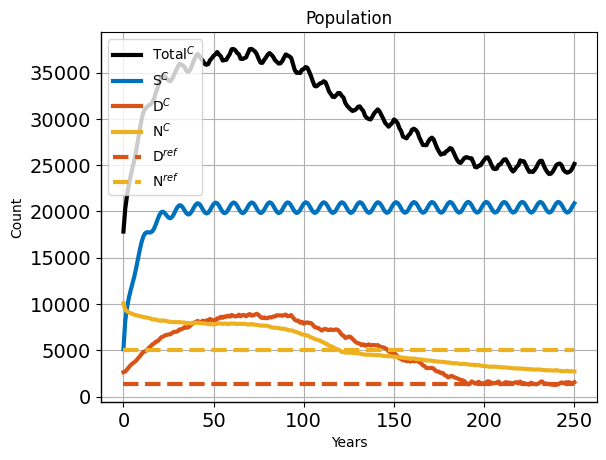

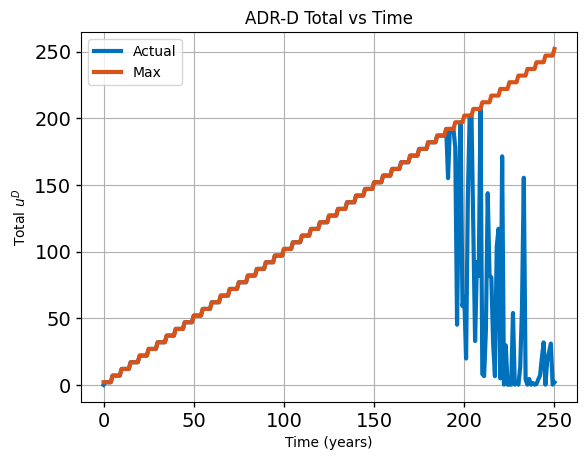

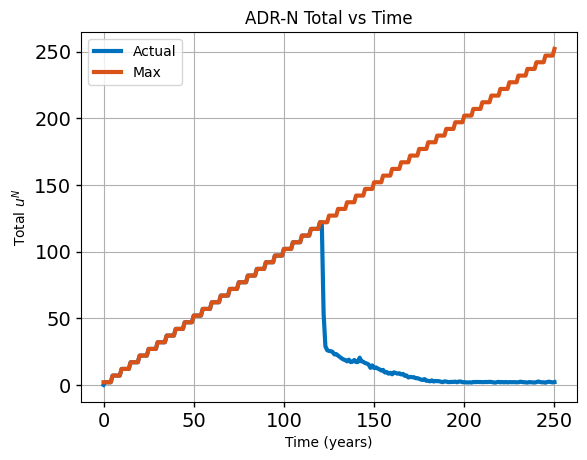

In [150]:
# Plots
colors = [
    [0, 0, 0],
    [0, 0.4470, 0.7410],
    [0.8500, 0.3250, 0.0980],
    [0.9290, 0.6940, 0.1250],
    [0.4940, 0.1840, 0.5560],
    [0.4660, 0.6740, 0.1880],
]
sel_LineWidth = 3
sel_MarkerWidth = 10
sel_LineWidthAxis = 1
sel_FontSize = 14


plt.figure(facecolor='w')
plt.grid(True)
# plt.plot(t_prop_nc, N_tot_sum_nc, ':', color=colors[0], linewidth=sel_LineWidth, label="Total$^{NC}$")
# plt.plot(t_prop_nc, S_sum_nc, ':', color=colors[1], linewidth=sel_LineWidth, label="S$^{NC}$")
# plt.plot(t_prop_nc, D_sum_nc, ':', color=colors[2], linewidth=sel_LineWidth, label="D$^{NC}$")
# plt.plot(t_prop_nc, N_sum_nc, ':', color=colors[3], linewidth=sel_LineWidth, label="N$^{NC}$")
plt.plot(t_prop, N_tot_sum, '-', color=colors[0], linewidth=sel_LineWidth, label="Total$^{C}$")
plt.plot(t_prop, S_sum, '-', color=colors[1], linewidth=sel_LineWidth, label="S$^{C}$")
plt.plot(t_prop, D_sum, '-', color=colors[2], linewidth=sel_LineWidth, label="D$^{C}$")
plt.plot(t_prop, N_sum, '-', color=colors[3], linewidth=sel_LineWidth, label="N$^{C}$")
if K_p + K_d != 0:
    if np.sum(ref_S_dot) != 0 and K_p == 0:
        plt.plot(t_prop, np.sum(x0_S) + t_prop * np.sum(ref_S_dot), '--', color=colors[1], linewidth=sel_LineWidth, label="S$^{ref}$")
    else:
        plt.plot(t_prop, np.ones_like(t_prop) * np.sum(ref_S), '--', color=colors[1], linewidth=sel_LineWidth, label="S$^{ref}$")

if np.sum(ref_D_dot) != 0 and K_p_adrD == 0:
    plt.plot(t_prop, np.sum(x0_D) + t_prop * np.sum(ref_D_dot), '--', color=colors[2], linewidth=sel_LineWidth, label="D$^{ref}$")
elif K_p_adrD + K_d_adrD != 0:
    plt.plot(t_prop, np.ones_like(t_prop) * np.sum(ref_D), '--', color=colors[2], linewidth=sel_LineWidth, label="D$^{ref}$")

if np.sum(ref_N_dot) != 0 and K_p_adrN == 0:
    plt.plot(t_prop, np.sum(x0_N) + t_prop * np.sum(ref_N_dot), '--', color=colors[3], linewidth=sel_LineWidth, label="N$^{ref}$")
elif K_p_adrN + K_d_adrN != 0:
    plt.plot(t_prop, np.ones_like(t_prop) * np.sum(ref_N), '--', color=colors[3], linewidth=sel_LineWidth, label="N$^{ref}$")
plt.title("Population")
plt.xlabel("Years")
plt.ylabel("Count")
plt.legend(loc="best")
plt.gca().tick_params(axis='both', which='major', labelsize=sel_FontSize)
plt.gca().spines['bottom'].set_linewidth(sel_LineWidthAxis)
plt.gca().spines['left'].set_linewidth(sel_LineWidthAxis)
# plt.ylim(0,2510)
# plt.savefig("so_variation_no_fail.pdf", dpi=300)  


# Figure 1: ADR-D Total vs Time
plt.figure(facecolor='white')  # Set figure size for better visibility 
plt.title('ADR-D Total vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Total $u^D$')
plt.grid(True)
plt.plot(t_prop, -np.sum(adr_d_prop, axis=1), '-', linewidth=sel_LineWidth, color=colors[1], label='Actual') # Python uses 0-based indexing for colors
plt.plot(t_prop, -sat_D(np.array(t_prop)), '-', linewidth=sel_LineWidth, color=colors[2], label='Max') 
plt.xticks(fontsize=sel_FontSize)
plt.yticks(fontsize=sel_FontSize)
plt.gca().tick_params(width=sel_LineWidthAxis)
plt.legend(loc='best')

# Figure 2: ADR-N Total vs Time
plt.figure(facecolor='white')  # Set figure size 
plt.title('ADR-N Total vs Time')
plt.xlabel('Time (years)')
plt.ylabel('Total $u^N$')
plt.grid(True)
plt.plot(t_prop, -np.sum(adr_n_prop, axis=1), '-', linewidth=sel_LineWidth, color=colors[1], label='Actual') 
plt.plot(t_prop, -sat_N(np.array(t_prop)), '-', linewidth=sel_LineWidth, color=colors[2], label='Max') 
plt.xticks(fontsize=sel_FontSize)
plt.yticks(fontsize=sel_FontSize)
plt.gca().tick_params(width=sel_LineWidthAxis)
plt.legend(loc='best')

plt.show()